In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [2]:
# move into project directory
repo_name = "Image-Colorization"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/Image-Colorization
common	     dataloading  Index.ipynb  output		     README.md	       transforms
config.yaml  experiments  index.py     preprocess	     requirements.txt  visualization
data	     Index_bc.py  models       project-structure.md  run.yaml


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder


In [3]:
# setup some imports
#custom imports
from transforms.transforms import ToTensor
from dataloading.datareader import DataReader
from dataloading.dataset import CustomDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_saved_model, get_modelinfo, get_model_data
from models.unet import UNet
from models.custom_models import get_model

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.experiments import Experiment
from visualization.visualization import Visualization
from experiments.test_model import ModelTester

In [4]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'L', 'data_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/data', 'device': 'cpu', 'output_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization', 'use_gpu': False, 'y_key': 'AB'}


In [5]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 128, 'val_split_method': 'fixed-split', 'k': 3, 'val_percentage': 20, 'loss': 'mse', 'batch_interval': 512, 'epoch_interval': 1, 'num_epochs': 1000}, 'model': {'name': 'unet', 'optimizer': 'SGD', 'lr': 1e-05, 'weight_decay': 1e-06, 'amsgrad': False, 'momentum': 0.9}, 'test_model': False}


In [6]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [7]:
#save X_key and y_key
save2config('X_key', 'L')
save2config('y_key', 'AB')

#preprocess data or load preprocessed data
dr = DataReader()
ds = dr.get_split_data()
Ltr, ABtr, ftr_len = ds['Ltr'], ds['ABtr'], ds['ftr_len']
Lte, ABte, te_len = ds['Lte'], ds['ABte'], ds['te_len']
print('Shape of X and y:', ds['Ltr'].shape, ds['ABtr'].shape)
print('Full Train data length:', ftr_len)
print('Test data length:', te_len, '\n')

#transform data
composed_transforms =  transforms.Compose([
    ToTensor()
])
#convert to dataset
ftr_dataset = CustomDataset(Ltr, ABtr, ftr_len)
te_dataset = CustomDataset(Lte, ABte, te_len)


Shape of X and y: (50000, 1, 32, 32) (50000, 2, 32, 32)
Full Train data length: 50000
Test data length: 10 



In [10]:
#model training

exp = Experiment(exp_params["model"]["name"], ftr_dataset)
model_history = exp.train()

Running straight split
Loading saved model
	Running Epoch 557


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.83it/s]


	Epoch 557 Training Loss: 0.02143206540644169
	Epoch 557 Validation Loss: 0.021217580208182336
	Epoch 557 Validation Accuracy: 0.0

	Running Epoch 558


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 60.71it/s]


	Epoch 558 Training Loss: 0.021418484940752387
	Epoch 558 Validation Loss: 0.02125333419442177
	Epoch 558 Validation Accuracy: 0.0

	Running Epoch 559


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.89it/s]


	Epoch 559 Training Loss: 0.02142367021292448
	Epoch 559 Validation Loss: 0.020736521017551423
	Epoch 559 Validation Accuracy: 0.0

	Running Epoch 560


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.67it/s]


	Epoch 560 Training Loss: 0.02138507044836879
	Epoch 560 Validation Loss: 0.020844392727315426
	Epoch 560 Validation Accuracy: 0.0

	Running Epoch 561


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.62it/s]


	Epoch 561 Training Loss: 0.02140339979417622
	Epoch 561 Validation Loss: 0.021116516555845736
	Epoch 561 Validation Accuracy: 0.0

	Running Epoch 562


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.23it/s]


	Epoch 562 Training Loss: 0.021385163543373345
	Epoch 562 Validation Loss: 0.02099021503329277
	Epoch 562 Validation Accuracy: 0.0

	Running Epoch 563


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.27it/s]


	Epoch 563 Training Loss: 0.021384899131953718
	Epoch 563 Validation Loss: 0.020926647964119912
	Epoch 563 Validation Accuracy: 0.0

	Running Epoch 564


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.05it/s]


	Epoch 564 Training Loss: 0.021353530333563686
	Epoch 564 Validation Loss: 0.02050471859574318
	Epoch 564 Validation Accuracy: 0.0

	Running Epoch 565


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.04it/s]


	Epoch 565 Training Loss: 0.021344620960205795
	Epoch 565 Validation Loss: 0.020788091093301774
	Epoch 565 Validation Accuracy: 0.0

	Running Epoch 566


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.50it/s]


	Epoch 566 Training Loss: 0.021299216612428427
	Epoch 566 Validation Loss: 0.02058392735719681
	Epoch 566 Validation Accuracy: 0.0

	Running Epoch 567


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.81it/s]


	Epoch 567 Training Loss: 0.021291302569955588
	Epoch 567 Validation Loss: 0.021184399829804898
	Epoch 567 Validation Accuracy: 0.0

	Running Epoch 568


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.85it/s]


	Epoch 568 Training Loss: 0.021295288007333876
	Epoch 568 Validation Loss: 0.02042044579088688
	Epoch 568 Validation Accuracy: 0.0

	Running Epoch 569


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.46it/s]


	Epoch 569 Training Loss: 0.02120835455432534
	Epoch 569 Validation Loss: 0.020794437423348428
	Epoch 569 Validation Accuracy: 0.0

	Running Epoch 570


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.48it/s]


	Epoch 570 Training Loss: 0.021238526005670427
	Epoch 570 Validation Loss: 0.02089726012609899
	Epoch 570 Validation Accuracy: 0.0

	Running Epoch 571


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.55it/s]


	Epoch 571 Training Loss: 0.02129399563074112
	Epoch 571 Validation Loss: 0.020871642303466796
	Epoch 571 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 572


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.66it/s]


	Epoch 572 Training Loss: 0.021212685433030128
	Epoch 572 Validation Loss: 0.02056193740963936
	Epoch 572 Validation Accuracy: 0.0

	Running Epoch 573


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.37it/s]


	Epoch 573 Training Loss: 0.021238199186325073
	Epoch 573 Validation Loss: 0.020869539311528205
	Epoch 573 Validation Accuracy: 0.0

	Running Epoch 574


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.11it/s]


	Epoch 574 Training Loss: 0.021191924622654915
	Epoch 574 Validation Loss: 0.020764077062904836
	Epoch 574 Validation Accuracy: 0.0

	Running Epoch 575


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.66it/s]


	Epoch 575 Training Loss: 0.021189123690128327
	Epoch 575 Validation Loss: 0.02060413143336773
	Epoch 575 Validation Accuracy: 0.0

	Running Epoch 576


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.18it/s]


	Epoch 576 Training Loss: 0.021190639600157737
	Epoch 576 Validation Loss: 0.020433921375870703
	Epoch 576 Validation Accuracy: 0.0

	Running Epoch 577


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.45it/s]


	Epoch 577 Training Loss: 0.021162611421570183
	Epoch 577 Validation Loss: 0.02073924989402294
	Epoch 577 Validation Accuracy: 0.0

	Running Epoch 578


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.47it/s]


	Epoch 578 Training Loss: 0.021125105695985257
	Epoch 578 Validation Loss: 0.02061071462929249
	Epoch 578 Validation Accuracy: 0.0

	Running Epoch 579


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.11it/s]


	Epoch 579 Training Loss: 0.021126801351457836
	Epoch 579 Validation Loss: 0.020536957032233478
	Epoch 579 Validation Accuracy: 0.0

	Running Epoch 580


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.63it/s]


	Epoch 580 Training Loss: 0.02107473402954638
	Epoch 580 Validation Loss: 0.020374439950287343
	Epoch 580 Validation Accuracy: 0.0

	Running Epoch 581


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.36it/s]


	Epoch 581 Training Loss: 0.02108166938573122
	Epoch 581 Validation Loss: 0.02059003944993019
	Epoch 581 Validation Accuracy: 0.0

	Running Epoch 582


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.10it/s]


	Epoch 582 Training Loss: 0.02106393210887909
	Epoch 582 Validation Loss: 0.020637839233875275
	Epoch 582 Validation Accuracy: 0.0

	Running Epoch 583


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.44it/s]


	Epoch 583 Training Loss: 0.02105111543033272
	Epoch 583 Validation Loss: 0.0203768221616745
	Epoch 583 Validation Accuracy: 0.0

	Running Epoch 584


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.41it/s]


	Epoch 584 Training Loss: 0.02105553527921438
	Epoch 584 Validation Loss: 0.020562950128316878
	Epoch 584 Validation Accuracy: 0.0

	Running Epoch 585


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.08it/s]


	Epoch 585 Training Loss: 0.021030492006242275
	Epoch 585 Validation Loss: 0.020420536106824875
	Epoch 585 Validation Accuracy: 0.0

	Running Epoch 586


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.93it/s]


	Epoch 586 Training Loss: 0.0210242419116199
	Epoch 586 Validation Loss: 0.02053865596204996
	Epoch 586 Validation Accuracy: 0.0

	Running Epoch 587


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.49it/s]


	Epoch 587 Training Loss: 0.020971053186058998
	Epoch 587 Validation Loss: 0.020767478695511817
	Epoch 587 Validation Accuracy: 0.0

	Running Epoch 588


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.89it/s]


	Epoch 588 Training Loss: 0.020988159672915934
	Epoch 588 Validation Loss: 0.020474798068404198
	Epoch 588 Validation Accuracy: 0.0

	Running Epoch 589


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.32it/s]


	Epoch 589 Training Loss: 0.020995565854012965
	Epoch 589 Validation Loss: 0.02056566639840603
	Epoch 589 Validation Accuracy: 0.0

	Running Epoch 590


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.36it/s]


	Epoch 590 Training Loss: 0.020935149493813515
	Epoch 590 Validation Loss: 0.02037628149241209
	Epoch 590 Validation Accuracy: 0.0

	Running Epoch 591


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.12it/s]


	Epoch 591 Training Loss: 0.020949504406750204
	Epoch 591 Validation Loss: 0.02038813147190958
	Epoch 591 Validation Accuracy: 0.0

	Running Epoch 592


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.79it/s]


	Epoch 592 Training Loss: 0.020953729913383724
	Epoch 592 Validation Loss: 0.02004848640114069
	Epoch 592 Validation Accuracy: 0.0

	Running Epoch 593


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.60it/s]


	Epoch 593 Training Loss: 0.0209342995069921
	Epoch 593 Validation Loss: 0.020219993898272514
	Epoch 593 Validation Accuracy: 0.0

	Running Epoch 594


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.95it/s]


	Epoch 594 Training Loss: 0.020894277019798756
	Epoch 594 Validation Loss: 0.020532575860619545
	Epoch 594 Validation Accuracy: 0.0

	Running Epoch 595


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.42it/s]


	Epoch 595 Training Loss: 0.020859400510042907
	Epoch 595 Validation Loss: 0.02055717476308346
	Epoch 595 Validation Accuracy: 0.0

	Running Epoch 596


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.63it/s]


	Epoch 596 Training Loss: 0.020865634969621898
	Epoch 596 Validation Loss: 0.02027577610351145
	Epoch 596 Validation Accuracy: 0.0

	Running Epoch 597


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.15it/s]


	Epoch 597 Training Loss: 0.02085552154071629
	Epoch 597 Validation Loss: 0.020207025110721588
	Epoch 597 Validation Accuracy: 0.0

	Running Epoch 598


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.16it/s]


	Epoch 598 Training Loss: 0.020849158293008804
	Epoch 598 Validation Loss: 0.02032484418749809
	Epoch 598 Validation Accuracy: 0.0

	Running Epoch 599


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.36it/s]


	Epoch 599 Training Loss: 0.020813003481179475
	Epoch 599 Validation Loss: 0.020460347312688826
	Epoch 599 Validation Accuracy: 0.0

	Running Epoch 600


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.42it/s]


	Epoch 600 Training Loss: 0.020830106460116803
	Epoch 600 Validation Loss: 0.020548324489593504
	Epoch 600 Validation Accuracy: 0.0

	Running Epoch 601


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.97it/s]


	Epoch 601 Training Loss: 0.020791648451052608
	Epoch 601 Validation Loss: 0.020420735570788384
	Epoch 601 Validation Accuracy: 0.0

	Running Epoch 602


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.68it/s]


	Epoch 602 Training Loss: 0.020797417421638965
	Epoch 602 Validation Loss: 0.020317909897863865
	Epoch 602 Validation Accuracy: 0.0

	Running Epoch 603


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.37it/s]


	Epoch 603 Training Loss: 0.020751561779156328
	Epoch 603 Validation Loss: 0.020608972717821597
	Epoch 603 Validation Accuracy: 0.0

	Running Epoch 604


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.06it/s]


	Epoch 604 Training Loss: 0.02074639317691326
	Epoch 604 Validation Loss: 0.020242921337485315
	Epoch 604 Validation Accuracy: 0.0

	Running Epoch 605


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.64it/s]


	Epoch 605 Training Loss: 0.020705884090811016
	Epoch 605 Validation Loss: 0.020234967646002768
	Epoch 605 Validation Accuracy: 0.0

	Running Epoch 606


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.39it/s]


	Epoch 606 Training Loss: 0.020747792662680148
	Epoch 606 Validation Loss: 0.020120519876480104
	Epoch 606 Validation Accuracy: 0.0

	Running Epoch 607


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.20it/s]


	Epoch 607 Training Loss: 0.02070654580295086
	Epoch 607 Validation Loss: 0.020093098002672196
	Epoch 607 Validation Accuracy: 0.0

	Running Epoch 608


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.71it/s]


	Epoch 608 Training Loss: 0.0206755367398262
	Epoch 608 Validation Loss: 0.020303480169177057
	Epoch 608 Validation Accuracy: 0.0

	Running Epoch 609


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.71it/s]


	Epoch 609 Training Loss: 0.020696048133075236
	Epoch 609 Validation Loss: 0.02023279290795326
	Epoch 609 Validation Accuracy: 0.0

	Running Epoch 610


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.79it/s]


	Epoch 610 Training Loss: 0.020670262218266726
	Epoch 610 Validation Loss: 0.019998660758137703
	Epoch 610 Validation Accuracy: 0.0

	Running Epoch 611


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.44it/s]


	Epoch 611 Training Loss: 0.02064984964132309
	Epoch 611 Validation Loss: 0.02015729795694351
	Epoch 611 Validation Accuracy: 0.0

	Running Epoch 612


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.55it/s]


	Epoch 612 Training Loss: 0.020615819478034973
	Epoch 612 Validation Loss: 0.020406840968132018
	Epoch 612 Validation Accuracy: 0.0

	Running Epoch 613


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.63it/s]


	Epoch 613 Training Loss: 0.020571483916603028
	Epoch 613 Validation Loss: 0.01995311502814293
	Epoch 613 Validation Accuracy: 0.0

	Running Epoch 614


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.24it/s]


	Epoch 614 Training Loss: 0.02059874381199479
	Epoch 614 Validation Loss: 0.020192461064457892
	Epoch 614 Validation Accuracy: 0.0

	Running Epoch 615


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.19it/s]


	Epoch 615 Training Loss: 0.02057540181931108
	Epoch 615 Validation Loss: 0.020138064879179
	Epoch 615 Validation Accuracy: 0.0

	Running Epoch 616


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.94it/s]


	Epoch 616 Training Loss: 0.020564059138298035
	Epoch 616 Validation Loss: 0.019873850847780705
	Epoch 616 Validation Accuracy: 0.0

	Running Epoch 617


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.01it/s]


	Epoch 617 Training Loss: 0.02055610918700695
	Epoch 617 Validation Loss: 0.019694483744353057
	Epoch 617 Validation Accuracy: 0.0

	Running Epoch 618


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.18it/s]


	Epoch 618 Training Loss: 0.02049130801409483
	Epoch 618 Validation Loss: 0.020113987296819687
	Epoch 618 Validation Accuracy: 0.0

	Running Epoch 619


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.72it/s]


	Epoch 619 Training Loss: 0.020523629828542472
	Epoch 619 Validation Loss: 0.019817401051521303
	Epoch 619 Validation Accuracy: 0.0

	Running Epoch 620


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.18it/s]


	Epoch 620 Training Loss: 0.02051214563883841
	Epoch 620 Validation Loss: 0.02006891757249832
	Epoch 620 Validation Accuracy: 0.0

	Running Epoch 621


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.70it/s]


	Epoch 621 Training Loss: 0.020529539930447937
	Epoch 621 Validation Loss: 0.020076960811018944
	Epoch 621 Validation Accuracy: 0.0

	Running Epoch 622


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.47it/s]


	Epoch 622 Training Loss: 0.020443888729065655
	Epoch 622 Validation Loss: 0.019828508185595273
	Epoch 622 Validation Accuracy: 0.0

	Running Epoch 623


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.10it/s]


	Epoch 623 Training Loss: 0.020458829725533725
	Epoch 623 Validation Loss: 0.019639681829512118
	Epoch 623 Validation Accuracy: 0.0

	Running Epoch 624


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.98it/s]


	Epoch 624 Training Loss: 0.020422824715822935
	Epoch 624 Validation Loss: 0.02028223015666008
	Epoch 624 Validation Accuracy: 0.0

	Running Epoch 625


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.37it/s]


	Epoch 625 Training Loss: 0.02043551236875355
	Epoch 625 Validation Loss: 0.019980566501617433
	Epoch 625 Validation Accuracy: 0.0

	Running Epoch 626


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.61it/s]


	Epoch 626 Training Loss: 0.020452063000202178
	Epoch 626 Validation Loss: 0.019968017745763064
	Epoch 626 Validation Accuracy: 0.0

	Running Epoch 627


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.03it/s]


	Epoch 627 Training Loss: 0.020396726386249064
	Epoch 627 Validation Loss: 0.019682120776176454
	Epoch 627 Validation Accuracy: 0.0

	Running Epoch 628


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.33it/s]


	Epoch 628 Training Loss: 0.020390080700814724
	Epoch 628 Validation Loss: 0.019875776693224906
	Epoch 628 Validation Accuracy: 0.0

	Running Epoch 629


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.19it/s]


	Epoch 629 Training Loss: 0.02034491221383214
	Epoch 629 Validation Loss: 0.019981718474626542
	Epoch 629 Validation Accuracy: 0.0

	Running Epoch 630


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.61it/s]


	Epoch 630 Training Loss: 0.020355433082580567
	Epoch 630 Validation Loss: 0.019879856984317303
	Epoch 630 Validation Accuracy: 0.0

	Running Epoch 631


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.12it/s]


	Epoch 631 Training Loss: 0.02034495566636324
	Epoch 631 Validation Loss: 0.0197938891351223
	Epoch 631 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 632


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.10it/s]


	Epoch 632 Training Loss: 0.020307808071374892
	Epoch 632 Validation Loss: 0.01965468834042549
	Epoch 632 Validation Accuracy: 0.0

	Running Epoch 633


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.33it/s]


	Epoch 633 Training Loss: 0.020301100548356772
	Epoch 633 Validation Loss: 0.020153571605682374
	Epoch 633 Validation Accuracy: 0.0

	Running Epoch 634


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.46it/s]


	Epoch 634 Training Loss: 0.020304700304567814
	Epoch 634 Validation Loss: 0.019761007916927337
	Epoch 634 Validation Accuracy: 0.0

	Running Epoch 635


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.11it/s]


	Epoch 635 Training Loss: 0.02027081395611167
	Epoch 635 Validation Loss: 0.01971295197531581
	Epoch 635 Validation Accuracy: 0.0

	Running Epoch 636


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.14it/s]


	Epoch 636 Training Loss: 0.020296591721475125
	Epoch 636 Validation Loss: 0.019511193001270292
	Epoch 636 Validation Accuracy: 0.0

	Running Epoch 637


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.45it/s]


	Epoch 637 Training Loss: 0.020239439438655974
	Epoch 637 Validation Loss: 0.01966579186320305
	Epoch 637 Validation Accuracy: 0.0

	Running Epoch 638


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.15it/s]


	Epoch 638 Training Loss: 0.020226805883273483
	Epoch 638 Validation Loss: 0.019934970152378082
	Epoch 638 Validation Accuracy: 0.0

	Running Epoch 639


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.44it/s]


	Epoch 639 Training Loss: 0.020248894323408605
	Epoch 639 Validation Loss: 0.01955805023610592
	Epoch 639 Validation Accuracy: 0.0

	Running Epoch 640


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.06it/s]


	Epoch 640 Training Loss: 0.020204744885116817
	Epoch 640 Validation Loss: 0.019522486574947834
	Epoch 640 Validation Accuracy: 0.0

	Running Epoch 641


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.13it/s]


	Epoch 641 Training Loss: 0.020176294782012702
	Epoch 641 Validation Loss: 0.0198032095015049
	Epoch 641 Validation Accuracy: 0.0

	Running Epoch 642


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.01it/s]


	Epoch 642 Training Loss: 0.020175928071513773
	Epoch 642 Validation Loss: 0.01979709047675133
	Epoch 642 Validation Accuracy: 0.0

	Running Epoch 643


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.67it/s]


	Epoch 643 Training Loss: 0.020128436236828567
	Epoch 643 Validation Loss: 0.01967387915253639
	Epoch 643 Validation Accuracy: 0.0

	Running Epoch 644


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.48it/s]


	Epoch 644 Training Loss: 0.02012918243482709
	Epoch 644 Validation Loss: 0.019667219111323356
	Epoch 644 Validation Accuracy: 0.0

	Running Epoch 645


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.09it/s]


	Epoch 645 Training Loss: 0.020126852294802666
	Epoch 645 Validation Loss: 0.0198213036775589
	Epoch 645 Validation Accuracy: 0.0

	Running Epoch 646


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.24it/s]


	Epoch 646 Training Loss: 0.02013311182409525
	Epoch 646 Validation Loss: 0.019583926337957382
	Epoch 646 Validation Accuracy: 0.0

	Running Epoch 647


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.20it/s]


	Epoch 647 Training Loss: 0.020072383128479122
	Epoch 647 Validation Loss: 0.019611820486187936
	Epoch 647 Validation Accuracy: 0.0

	Running Epoch 648


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.07it/s]


	Epoch 648 Training Loss: 0.020052992399781942
	Epoch 648 Validation Loss: 0.019658954484015702
	Epoch 648 Validation Accuracy: 0.0

	Running Epoch 649


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.89it/s]


	Epoch 649 Training Loss: 0.02006985665410757
	Epoch 649 Validation Loss: 0.019622304305434227
	Epoch 649 Validation Accuracy: 0.0

	Running Epoch 650


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.44it/s]


	Epoch 650 Training Loss: 0.020048502224311232
	Epoch 650 Validation Loss: 0.019460737779736517
	Epoch 650 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 651


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.03it/s]


	Epoch 651 Training Loss: 0.020006508028507234
	Epoch 651 Validation Loss: 0.019418941116333008
	Epoch 651 Validation Accuracy: 0.0

	Running Epoch 652


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.05it/s]


	Epoch 652 Training Loss: 0.020005384183675052
	Epoch 652 Validation Loss: 0.01936031059026718
	Epoch 652 Validation Accuracy: 0.0

	Running Epoch 653


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.62it/s]


	Epoch 653 Training Loss: 0.019968296409770846
	Epoch 653 Validation Loss: 0.019289654674381016
	Epoch 653 Validation Accuracy: 0.0

	Running Epoch 654


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.19it/s]


	Epoch 654 Training Loss: 0.01994621530920267
	Epoch 654 Validation Loss: 0.019557227382063867
	Epoch 654 Validation Accuracy: 0.0

	Running Epoch 655


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.40it/s]


	Epoch 655 Training Loss: 0.01996396626085043
	Epoch 655 Validation Loss: 0.01974714975953102
	Epoch 655 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 656


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.32it/s]


	Epoch 656 Training Loss: 0.019937328031659127
	Epoch 656 Validation Loss: 0.01960226404219866
	Epoch 656 Validation Accuracy: 0.0

	Running Epoch 657


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.22it/s]


	Epoch 657 Training Loss: 0.019924573756381868
	Epoch 657 Validation Loss: 0.019537435045838356
	Epoch 657 Validation Accuracy: 0.0

	Running Epoch 658


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.17it/s]


	Epoch 658 Training Loss: 0.019908338965475558
	Epoch 658 Validation Loss: 0.019500074332952498
	Epoch 658 Validation Accuracy: 0.0

	Running Epoch 659


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


	Epoch 659 Training Loss: 0.01991509191915393
	Epoch 659 Validation Loss: 0.019104260218143463
	Epoch 659 Validation Accuracy: 0.0

	Running Epoch 660


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.25it/s]


	Epoch 660 Training Loss: 0.019884528166614474
	Epoch 660 Validation Loss: 0.01945825548171997
	Epoch 660 Validation Accuracy: 0.0

	Running Epoch 661


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.05it/s]


	Epoch 661 Training Loss: 0.019858597876131534
	Epoch 661 Validation Loss: 0.019275200030207634
	Epoch 661 Validation Accuracy: 0.0

	Running Epoch 662


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


	Epoch 662 Training Loss: 0.019857452218979596
	Epoch 662 Validation Loss: 0.0194531426101923
	Epoch 662 Validation Accuracy: 0.0

	Running Epoch 663


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.97it/s]


	Epoch 663 Training Loss: 0.019837252286821604
	Epoch 663 Validation Loss: 0.019348180048167705
	Epoch 663 Validation Accuracy: 0.0

	Running Epoch 664


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.30it/s]


	Epoch 664 Training Loss: 0.019824376552924513
	Epoch 664 Validation Loss: 0.01916753463745117
	Epoch 664 Validation Accuracy: 0.0

	Running Epoch 665


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.25it/s]


	Epoch 665 Training Loss: 0.019789988470077513
	Epoch 665 Validation Loss: 0.01926069142818451
	Epoch 665 Validation Accuracy: 0.0

	Running Epoch 666


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.59it/s]


	Epoch 666 Training Loss: 0.019791385528445244
	Epoch 666 Validation Loss: 0.01916345229744911
	Epoch 666 Validation Accuracy: 0.0

	Running Epoch 667


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.13it/s]


	Epoch 667 Training Loss: 0.019774291110783816
	Epoch 667 Validation Loss: 0.01958887030137703
	Epoch 667 Validation Accuracy: 0.0

	Running Epoch 668


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.43it/s]


	Epoch 668 Training Loss: 0.019737578306719662
	Epoch 668 Validation Loss: 0.019327674984931945
	Epoch 668 Validation Accuracy: 0.0

	Running Epoch 669


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.89it/s]


	Epoch 669 Training Loss: 0.01974823349006474
	Epoch 669 Validation Loss: 0.01904092819094658
	Epoch 669 Validation Accuracy: 0.0

	Running Epoch 670


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.82it/s]


	Epoch 670 Training Loss: 0.019734713358432056
	Epoch 670 Validation Loss: 0.01930848455801606
	Epoch 670 Validation Accuracy: 0.0

	Running Epoch 671


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.93it/s]


	Epoch 671 Training Loss: 0.019681169613450764
	Epoch 671 Validation Loss: 0.019125285372138024
	Epoch 671 Validation Accuracy: 0.0

	Running Epoch 672


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.94it/s]


	Epoch 672 Training Loss: 0.019720713946968317
	Epoch 672 Validation Loss: 0.019489604496955873
	Epoch 672 Validation Accuracy: 0.0

	Running Epoch 673


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.30it/s]


	Epoch 673 Training Loss: 0.019667291758954524
	Epoch 673 Validation Loss: 0.01931144504994154
	Epoch 673 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 674


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.96it/s]


	Epoch 674 Training Loss: 0.019688192570582033
	Epoch 674 Validation Loss: 0.01909299329519272
	Epoch 674 Validation Accuracy: 0.0

	Running Epoch 675


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.88it/s]


	Epoch 675 Training Loss: 0.019646427600830792
	Epoch 675 Validation Loss: 0.01937814346314408
	Epoch 675 Validation Accuracy: 0.0

	Running Epoch 676


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.94it/s]


	Epoch 676 Training Loss: 0.019635654531419276
	Epoch 676 Validation Loss: 0.019136423394083977
	Epoch 676 Validation Accuracy: 0.0

	Running Epoch 677


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.61it/s]


	Epoch 677 Training Loss: 0.019636306069977582
	Epoch 677 Validation Loss: 0.019005242417752744
	Epoch 677 Validation Accuracy: 0.0

	Running Epoch 678


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.17it/s]


	Epoch 678 Training Loss: 0.01958510810881853
	Epoch 678 Validation Loss: 0.019207203885912894
	Epoch 678 Validation Accuracy: 0.0

	Running Epoch 679


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.83it/s]


	Epoch 679 Training Loss: 0.01957786946259439
	Epoch 679 Validation Loss: 0.019223400443792345
	Epoch 679 Validation Accuracy: 0.0

	Running Epoch 680


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.77it/s]


	Epoch 680 Training Loss: 0.019544669208303094
	Epoch 680 Validation Loss: 0.019209264078736306
	Epoch 680 Validation Accuracy: 0.0

	Running Epoch 681


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.75it/s]


	Epoch 681 Training Loss: 0.019560851021111013
	Epoch 681 Validation Loss: 0.01891307423710823
	Epoch 681 Validation Accuracy: 0.0

	Running Epoch 682


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.42it/s]


	Epoch 682 Training Loss: 0.019569212816655635
	Epoch 682 Validation Loss: 0.019008534824848176
	Epoch 682 Validation Accuracy: 0.0

	Running Epoch 683


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.28it/s]


	Epoch 683 Training Loss: 0.019540492895618083
	Epoch 683 Validation Loss: 0.01895868715643883
	Epoch 683 Validation Accuracy: 0.0

	Running Epoch 684


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.12it/s]


	Epoch 684 Training Loss: 0.019495191027969122
	Epoch 684 Validation Loss: 0.018913207983970642
	Epoch 684 Validation Accuracy: 0.0

	Running Epoch 685


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.01it/s]


	Epoch 685 Training Loss: 0.019495702666044234
	Epoch 685 Validation Loss: 0.01925474150925875
	Epoch 685 Validation Accuracy: 0.0

	Running Epoch 686


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.75it/s]


	Epoch 686 Training Loss: 0.019419193929061294
	Epoch 686 Validation Loss: 0.01907917360663414
	Epoch 686 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 687


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.97it/s]


	Epoch 687 Training Loss: 0.01950442109629512
	Epoch 687 Validation Loss: 0.019182661154866217
	Epoch 687 Validation Accuracy: 0.0

	Running Epoch 688


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.37it/s]


	Epoch 688 Training Loss: 0.019431867554038765
	Epoch 688 Validation Loss: 0.019018953941762447
	Epoch 688 Validation Accuracy: 0.0

	Running Epoch 689


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.23it/s]


	Epoch 689 Training Loss: 0.01939559166058898
	Epoch 689 Validation Loss: 0.01883270938396454
	Epoch 689 Validation Accuracy: 0.0

	Running Epoch 690


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.66it/s]


	Epoch 690 Training Loss: 0.019366236447170376
	Epoch 690 Validation Loss: 0.018756882652640344
	Epoch 690 Validation Accuracy: 0.0

	Running Epoch 691


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.67it/s]


	Epoch 691 Training Loss: 0.019381128969788552
	Epoch 691 Validation Loss: 0.018872402514517307
	Epoch 691 Validation Accuracy: 0.0

	Running Epoch 692


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.92it/s]


	Epoch 692 Training Loss: 0.019400629138574006
	Epoch 692 Validation Loss: 0.01885845994949341
	Epoch 692 Validation Accuracy: 0.0

	Running Epoch 693


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.25it/s]


	Epoch 693 Training Loss: 0.019336452582478524
	Epoch 693 Validation Loss: 0.018873299303650858
	Epoch 693 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 694


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.74it/s]


	Epoch 694 Training Loss: 0.019332578133791686
	Epoch 694 Validation Loss: 0.018670332825183867
	Epoch 694 Validation Accuracy: 0.0

	Running Epoch 695


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.80it/s]


	Epoch 695 Training Loss: 0.019345374526828527
	Epoch 695 Validation Loss: 0.01881493556201458
	Epoch 695 Validation Accuracy: 0.0

	Running Epoch 696


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.27it/s]


	Epoch 696 Training Loss: 0.01932279272079468
	Epoch 696 Validation Loss: 0.018851553684473037
	Epoch 696 Validation Accuracy: 0.0

	Running Epoch 697


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.15it/s]


	Epoch 697 Training Loss: 0.019262638726085423
	Epoch 697 Validation Loss: 0.018888250452280046
	Epoch 697 Validation Accuracy: 0.0

	Running Epoch 698


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.02it/s]


	Epoch 698 Training Loss: 0.01925275141224265
	Epoch 698 Validation Loss: 0.018474722236394882
	Epoch 698 Validation Accuracy: 0.0

	Running Epoch 699


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.00it/s]


	Epoch 699 Training Loss: 0.019239412000402807
	Epoch 699 Validation Loss: 0.018797569847106933
	Epoch 699 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 700


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.13it/s]


	Epoch 700 Training Loss: 0.019239776431396603
	Epoch 700 Validation Loss: 0.018515042540431022
	Epoch 700 Validation Accuracy: 0.0

	Running Epoch 701


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.91it/s]


	Epoch 701 Training Loss: 0.01923771811015904
	Epoch 701 Validation Loss: 0.018553302854299545
	Epoch 701 Validation Accuracy: 0.0

	Running Epoch 702


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.95it/s]


	Epoch 702 Training Loss: 0.01919235675930977
	Epoch 702 Validation Loss: 0.018523696192353965
	Epoch 702 Validation Accuracy: 0.0

	Running Epoch 703


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.03it/s]


	Epoch 703 Training Loss: 0.01916166162341833
	Epoch 703 Validation Loss: 0.01861897706091404
	Epoch 703 Validation Accuracy: 0.0

	Running Epoch 704


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.49it/s]


	Epoch 704 Training Loss: 0.0191571408636868
	Epoch 704 Validation Loss: 0.01843759104311466
	Epoch 704 Validation Accuracy: 0.0

	Running Epoch 705


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.33it/s]


	Epoch 705 Training Loss: 0.01914308460056782
	Epoch 705 Validation Loss: 0.018747903305292128
	Epoch 705 Validation Accuracy: 0.0

	Running Epoch 706


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.02it/s]


	Epoch 706 Training Loss: 0.01912492004930973
	Epoch 706 Validation Loss: 0.01846127848774195
	Epoch 706 Validation Accuracy: 0.0

	Running Epoch 707


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.13it/s]


	Epoch 707 Training Loss: 0.019127203349769115
	Epoch 707 Validation Loss: 0.018655964547395706
	Epoch 707 Validation Accuracy: 0.0

	Running Epoch 708


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.41it/s]


	Epoch 708 Training Loss: 0.019079260801151396
	Epoch 708 Validation Loss: 0.01834810106009245
	Epoch 708 Validation Accuracy: 0.0

	Running Epoch 709


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.46it/s]


	Epoch 709 Training Loss: 0.01906995454877615
	Epoch 709 Validation Loss: 0.018619099351763726
	Epoch 709 Validation Accuracy: 0.0

	Running Epoch 710


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.08it/s]


	Epoch 710 Training Loss: 0.019093387781828643
	Epoch 710 Validation Loss: 0.018564695358276366
	Epoch 710 Validation Accuracy: 0.0

	Running Epoch 711


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.80it/s]


	Epoch 711 Training Loss: 0.019022011790052057
	Epoch 711 Validation Loss: 0.01881476317793131
	Epoch 711 Validation Accuracy: 0.0

	Running Epoch 712


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.04it/s]


	Epoch 712 Training Loss: 0.019056566549092532
	Epoch 712 Validation Loss: 0.018673928970098494
	Epoch 712 Validation Accuracy: 0.0

	Running Epoch 713


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.14it/s]


	Epoch 713 Training Loss: 0.01900784601550549
	Epoch 713 Validation Loss: 0.01841851946115494
	Epoch 713 Validation Accuracy: 0.0

	Running Epoch 714


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.56it/s]


	Epoch 714 Training Loss: 0.018980929747596385
	Epoch 714 Validation Loss: 0.018510337536036967
	Epoch 714 Validation Accuracy: 0.0

	Running Epoch 715


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.97it/s]


	Epoch 715 Training Loss: 0.01896390659697354
	Epoch 715 Validation Loss: 0.018440892021358013
	Epoch 715 Validation Accuracy: 0.0

	Running Epoch 716


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.78it/s]


	Epoch 716 Training Loss: 0.018948594884574413
	Epoch 716 Validation Loss: 0.018570448195934296
	Epoch 716 Validation Accuracy: 0.0

	Running Epoch 717


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.01it/s]


	Epoch 717 Training Loss: 0.01891581026688218
	Epoch 717 Validation Loss: 0.018551550106704236
	Epoch 717 Validation Accuracy: 0.0

	Running Epoch 718


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.00it/s]


	Epoch 718 Training Loss: 0.018899786258488895
	Epoch 718 Validation Loss: 0.018317901080846785
	Epoch 718 Validation Accuracy: 0.0

	Running Epoch 719


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.87it/s]


	Epoch 719 Training Loss: 0.01885150666311383
	Epoch 719 Validation Loss: 0.01843487217873335
	Epoch 719 Validation Accuracy: 0.0

	Running Epoch 720


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.30it/s]


	Epoch 720 Training Loss: 0.01886646743565798
	Epoch 720 Validation Loss: 0.01827298441827297
	Epoch 720 Validation Accuracy: 0.0

	Running Epoch 721


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.82it/s]


	Epoch 721 Training Loss: 0.018845221157371996
	Epoch 721 Validation Loss: 0.018695719802379607
	Epoch 721 Validation Accuracy: 0.0

	Running Epoch 722


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.31it/s]


	Epoch 722 Training Loss: 0.018825128804147242
	Epoch 722 Validation Loss: 0.01843771971538663
	Epoch 722 Validation Accuracy: 0.0

	Running Epoch 723


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.30it/s]


	Epoch 723 Training Loss: 0.01883216651007533
	Epoch 723 Validation Loss: 0.018487615102529525
	Epoch 723 Validation Accuracy: 0.0

	Running Epoch 724


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.22it/s]


	Epoch 724 Training Loss: 0.018825723830237985
	Epoch 724 Validation Loss: 0.01800066666826606
	Epoch 724 Validation Accuracy: 0.0

	Running Epoch 725


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.82it/s]


	Epoch 725 Training Loss: 0.018805497220903637
	Epoch 725 Validation Loss: 0.018187339186668396
	Epoch 725 Validation Accuracy: 0.0

	Running Epoch 726


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.89it/s]


	Epoch 726 Training Loss: 0.018769986733794212
	Epoch 726 Validation Loss: 0.018293029433488844
	Epoch 726 Validation Accuracy: 0.0

	Running Epoch 727


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.92it/s]


	Epoch 727 Training Loss: 0.01878329952955246
	Epoch 727 Validation Loss: 0.018205225163698196
	Epoch 727 Validation Accuracy: 0.0

	Running Epoch 728


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.19it/s]


	Epoch 728 Training Loss: 0.018742426016554237
	Epoch 728 Validation Loss: 0.01801133549362421
	Epoch 728 Validation Accuracy: 0.0

	Running Epoch 729


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.40it/s]


	Epoch 729 Training Loss: 0.018698703809082506
	Epoch 729 Validation Loss: 0.018322428303956986
	Epoch 729 Validation Accuracy: 0.0

	Running Epoch 730


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.79it/s]


	Epoch 730 Training Loss: 0.018744327015429735
	Epoch 730 Validation Loss: 0.018374383625388145
	Epoch 730 Validation Accuracy: 0.0

	Running Epoch 731


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.59it/s]


	Epoch 731 Training Loss: 0.018705578761547804
	Epoch 731 Validation Loss: 0.01801580649316311
	Epoch 731 Validation Accuracy: 0.0

	Running Epoch 732


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.08it/s]


	Epoch 732 Training Loss: 0.018732214711233975
	Epoch 732 Validation Loss: 0.018121358531713486
	Epoch 732 Validation Accuracy: 0.0

	Running Epoch 733


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.28it/s]


	Epoch 733 Training Loss: 0.018682345094904303
	Epoch 733 Validation Loss: 0.018108897385001183
	Epoch 733 Validation Accuracy: 0.0

	Running Epoch 734


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.07it/s]


	Epoch 734 Training Loss: 0.01863465182632208
	Epoch 734 Validation Loss: 0.01826587320463732
	Epoch 734 Validation Accuracy: 0.0

	Running Epoch 735


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.60it/s]


	Epoch 735 Training Loss: 0.018630855076760055
	Epoch 735 Validation Loss: 0.01804638661146164
	Epoch 735 Validation Accuracy: 0.0

	Running Epoch 736


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.99it/s]


	Epoch 736 Training Loss: 0.01861289555802941
	Epoch 736 Validation Loss: 0.01796370005309582
	Epoch 736 Validation Accuracy: 0.0

	Running Epoch 737


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.08it/s]


	Epoch 737 Training Loss: 0.018604298016428947
	Epoch 737 Validation Loss: 0.0182356261074543
	Epoch 737 Validation Accuracy: 0.0

	Running Epoch 738


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.91it/s]


	Epoch 738 Training Loss: 0.018580420819297432
	Epoch 738 Validation Loss: 0.018209191183745862
	Epoch 738 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 739


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.67it/s]


	Epoch 739 Training Loss: 0.018553841454535723
	Epoch 739 Validation Loss: 0.018361223050951957
	Epoch 739 Validation Accuracy: 0.0

	Running Epoch 740


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.53it/s]


	Epoch 740 Training Loss: 0.018561068174242974
	Epoch 740 Validation Loss: 0.017992051862180232
	Epoch 740 Validation Accuracy: 0.0

	Running Epoch 741


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.96it/s]


	Epoch 741 Training Loss: 0.018545267502963543
	Epoch 741 Validation Loss: 0.017909019845724107
	Epoch 741 Validation Accuracy: 0.0

	Running Epoch 742


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.40it/s]


	Epoch 742 Training Loss: 0.018482082449272276
	Epoch 742 Validation Loss: 0.017943590386211874
	Epoch 742 Validation Accuracy: 0.0

	Running Epoch 743


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.57it/s]


	Epoch 743 Training Loss: 0.018468846886605023
	Epoch 743 Validation Loss: 0.017794954857230188
	Epoch 743 Validation Accuracy: 0.0

	Running Epoch 744


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.14it/s]


	Epoch 744 Training Loss: 0.0184213673196733
	Epoch 744 Validation Loss: 0.01783632499575615
	Epoch 744 Validation Accuracy: 0.0

	Running Epoch 745


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.69it/s]


	Epoch 745 Training Loss: 0.018410585974156856
	Epoch 745 Validation Loss: 0.017690459349751473
	Epoch 745 Validation Accuracy: 0.0

	Running Epoch 746


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.79it/s]


	Epoch 746 Training Loss: 0.01840443500317633
	Epoch 746 Validation Loss: 0.017809276121854782
	Epoch 746 Validation Accuracy: 0.0

	Running Epoch 747


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.70it/s]


	Epoch 747 Training Loss: 0.01840303135961294
	Epoch 747 Validation Loss: 0.01773566585034132
	Epoch 747 Validation Accuracy: 0.0

	Running Epoch 748


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.63it/s]


	Epoch 748 Training Loss: 0.01841214555799961
	Epoch 748 Validation Loss: 0.01779670139551163
	Epoch 748 Validation Accuracy: 0.0

	Running Epoch 749


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.70it/s]


	Epoch 749 Training Loss: 0.018380938110500573
	Epoch 749 Validation Loss: 0.018012119487300516
	Epoch 749 Validation Accuracy: 0.0

	Running Epoch 750


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.08it/s]


	Epoch 750 Training Loss: 0.018334775339066984
	Epoch 750 Validation Loss: 0.017829043728113173
	Epoch 750 Validation Accuracy: 0.0

	Running Epoch 751


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.19it/s]


	Epoch 751 Training Loss: 0.018299375246092677
	Epoch 751 Validation Loss: 0.017513423225283622
	Epoch 751 Validation Accuracy: 0.0

	Running Epoch 752


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.62it/s]


	Epoch 752 Training Loss: 0.018289134123921396
	Epoch 752 Validation Loss: 0.01790697862058878
	Epoch 752 Validation Accuracy: 0.0

	Running Epoch 753


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.04it/s]


	Epoch 753 Training Loss: 0.01823373702093959
	Epoch 753 Validation Loss: 0.017503570139408113
	Epoch 753 Validation Accuracy: 0.0

	Running Epoch 754


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.57it/s]


	Epoch 754 Training Loss: 0.01822271349430084
	Epoch 754 Validation Loss: 0.017698881582170724
	Epoch 754 Validation Accuracy: 0.0

	Running Epoch 755


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.52it/s]


	Epoch 755 Training Loss: 0.018279412276670338
	Epoch 755 Validation Loss: 0.01786742182672024
	Epoch 755 Validation Accuracy: 0.0

	Running Epoch 756


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.77it/s]


	Epoch 756 Training Loss: 0.018219958183541895
	Epoch 756 Validation Loss: 0.017780763095617293
	Epoch 756 Validation Accuracy: 0.0

	Running Epoch 757


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.57it/s]


	Epoch 757 Training Loss: 0.018218003514409064
	Epoch 757 Validation Loss: 0.01777191674076021
	Epoch 757 Validation Accuracy: 0.0

	Running Epoch 758


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.72it/s]


	Epoch 758 Training Loss: 0.018161218066513538
	Epoch 758 Validation Loss: 0.017434212708473205
	Epoch 758 Validation Accuracy: 0.0

	Running Epoch 759


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.12it/s]


	Epoch 759 Training Loss: 0.018175190530717374
	Epoch 759 Validation Loss: 0.017773809343576433
	Epoch 759 Validation Accuracy: 0.0

	Running Epoch 760


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.15it/s]


	Epoch 760 Training Loss: 0.018160085525363683
	Epoch 760 Validation Loss: 0.017399540796875952
	Epoch 760 Validation Accuracy: 0.0

	Running Epoch 761


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.70it/s]


	Epoch 761 Training Loss: 0.018130278008803725
	Epoch 761 Validation Loss: 0.017438948240876197
	Epoch 761 Validation Accuracy: 0.0

	Running Epoch 762


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.95it/s]


	Epoch 762 Training Loss: 0.0181119535818696
	Epoch 762 Validation Loss: 0.017397055760025978
	Epoch 762 Validation Accuracy: 0.0

	Running Epoch 763


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.99it/s]


	Epoch 763 Training Loss: 0.018048002328164874
	Epoch 763 Validation Loss: 0.017468365709483624
	Epoch 763 Validation Accuracy: 0.0

	Running Epoch 764


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.62it/s]


	Epoch 764 Training Loss: 0.01805137556567788
	Epoch 764 Validation Loss: 0.017707568207383156
	Epoch 764 Validation Accuracy: 0.0

	Running Epoch 765


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.78it/s]


	Epoch 765 Training Loss: 0.01804018260538578
	Epoch 765 Validation Loss: 0.01766477857232094
	Epoch 765 Validation Accuracy: 0.0

	Running Epoch 766


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.74it/s]


	Epoch 766 Training Loss: 0.018053240441530942
	Epoch 766 Validation Loss: 0.017852273514866828
	Epoch 766 Validation Accuracy: 0.0

	Running Epoch 767


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.18it/s]


	Epoch 767 Training Loss: 0.01800893002077937
	Epoch 767 Validation Loss: 0.017308027136325836
	Epoch 767 Validation Accuracy: 0.0

	Running Epoch 768


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.78it/s]


	Epoch 768 Training Loss: 0.017990162348747254
	Epoch 768 Validation Loss: 0.017365171706676483
	Epoch 768 Validation Accuracy: 0.0

	Running Epoch 769


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.68it/s]


	Epoch 769 Training Loss: 0.017979660825803875
	Epoch 769 Validation Loss: 0.017396927139163017
	Epoch 769 Validation Accuracy: 0.0

	Running Epoch 770


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.33it/s]


	Epoch 770 Training Loss: 0.01798055248558521
	Epoch 770 Validation Loss: 0.017493350276350975
	Epoch 770 Validation Accuracy: 0.0

	Running Epoch 771


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.86it/s]


	Epoch 771 Training Loss: 0.0179046363838017
	Epoch 771 Validation Loss: 0.01746448397040367
	Epoch 771 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 772


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.22it/s]


	Epoch 772 Training Loss: 0.01789360333234072
	Epoch 772 Validation Loss: 0.017277428776025772
	Epoch 772 Validation Accuracy: 0.0

	Running Epoch 773


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.32it/s]


	Epoch 773 Training Loss: 0.01791378217935562
	Epoch 773 Validation Loss: 0.0174164871096611
	Epoch 773 Validation Accuracy: 0.0

	Running Epoch 774


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.53it/s]


	Epoch 774 Training Loss: 0.017822371830046178
	Epoch 774 Validation Loss: 0.017401791602373123
	Epoch 774 Validation Accuracy: 0.0

	Running Epoch 775


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.59it/s]


	Epoch 775 Training Loss: 0.01784384745247662
	Epoch 775 Validation Loss: 0.017291835683584212
	Epoch 775 Validation Accuracy: 0.0

	Running Epoch 776


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.45it/s]


	Epoch 776 Training Loss: 0.017842401980608703
	Epoch 776 Validation Loss: 0.017199825155735017
	Epoch 776 Validation Accuracy: 0.0

	Running Epoch 777


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.33it/s]


	Epoch 777 Training Loss: 0.017826311798393727
	Epoch 777 Validation Loss: 0.017162496761232614
	Epoch 777 Validation Accuracy: 0.0

	Running Epoch 778


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


	Epoch 778 Training Loss: 0.01780052404142916
	Epoch 778 Validation Loss: 0.017313368028402328
	Epoch 778 Validation Accuracy: 0.0

	Running Epoch 779


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.33it/s]


	Epoch 779 Training Loss: 0.0177554516389966
	Epoch 779 Validation Loss: 0.017351480263471605
	Epoch 779 Validation Accuracy: 0.0

	Running Epoch 780


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.66it/s]


	Epoch 780 Training Loss: 0.017727135344222187
	Epoch 780 Validation Loss: 0.01747801956832409
	Epoch 780 Validation Accuracy: 0.0

	Running Epoch 781


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


	Epoch 781 Training Loss: 0.017738602775894105
	Epoch 781 Validation Loss: 0.017112667909264564
	Epoch 781 Validation Accuracy: 0.0

	Running Epoch 782


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.11it/s]


	Epoch 782 Training Loss: 0.017697731717303395
	Epoch 782 Validation Loss: 0.016896589560806752
	Epoch 782 Validation Accuracy: 0.0

	Running Epoch 783


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.42it/s]


	Epoch 783 Training Loss: 0.017649902148172258
	Epoch 783 Validation Loss: 0.016890708398818968
	Epoch 783 Validation Accuracy: 0.0

	Running Epoch 784


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.85it/s]


	Epoch 784 Training Loss: 0.01767653649542481
	Epoch 784 Validation Loss: 0.01723453848063946
	Epoch 784 Validation Accuracy: 0.0

	Running Epoch 785


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.97it/s]


	Epoch 785 Training Loss: 0.01768497094027698
	Epoch 785 Validation Loss: 0.017041897112876177
	Epoch 785 Validation Accuracy: 0.0

	Running Epoch 786


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.14it/s]


	Epoch 786 Training Loss: 0.01760889465622604
	Epoch 786 Validation Loss: 0.0171758463203907
	Epoch 786 Validation Accuracy: 0.0

	Running Epoch 787


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.82it/s]


	Epoch 787 Training Loss: 0.017645525359362365
	Epoch 787 Validation Loss: 0.017157918226718902
	Epoch 787 Validation Accuracy: 0.0

	Running Epoch 788


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.69it/s]


	Epoch 788 Training Loss: 0.01759010191820562
	Epoch 788 Validation Loss: 0.01697130007147789
	Epoch 788 Validation Accuracy: 0.0

	Running Epoch 789


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.47it/s]


	Epoch 789 Training Loss: 0.017563365072757006
	Epoch 789 Validation Loss: 0.016978450472652912
	Epoch 789 Validation Accuracy: 0.0

	Running Epoch 790


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.34it/s]


	Epoch 790 Training Loss: 0.017573894425109027
	Epoch 790 Validation Loss: 0.017096542206406593
	Epoch 790 Validation Accuracy: 0.0

	Running Epoch 791


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.00it/s]


	Epoch 791 Training Loss: 0.017543319166079163
	Epoch 791 Validation Loss: 0.016920219467766583
	Epoch 791 Validation Accuracy: 0.0

	Running Epoch 792


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.78it/s]


	Epoch 792 Training Loss: 0.017514942130446434
	Epoch 792 Validation Loss: 0.01712181651890278
	Epoch 792 Validation Accuracy: 0.0

	Running Epoch 793


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.69it/s]


	Epoch 793 Training Loss: 0.017438466287404298
	Epoch 793 Validation Loss: 0.016720123398303987
	Epoch 793 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 794


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.94it/s]


	Epoch 794 Training Loss: 0.017489174602180718
	Epoch 794 Validation Loss: 0.016739047685265542
	Epoch 794 Validation Accuracy: 0.0

	Running Epoch 795


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.64it/s]


	Epoch 795 Training Loss: 0.017455689499899747
	Epoch 795 Validation Loss: 0.016747712624073027
	Epoch 795 Validation Accuracy: 0.0

	Running Epoch 796


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.63it/s]


	Epoch 796 Training Loss: 0.017465542210638525
	Epoch 796 Validation Loss: 0.01687834527492523
	Epoch 796 Validation Accuracy: 0.0

	Running Epoch 797


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.76it/s]


	Epoch 797 Training Loss: 0.01735740587487817
	Epoch 797 Validation Loss: 0.01695644001364708
	Epoch 797 Validation Accuracy: 0.0

	Running Epoch 798


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.32it/s]


	Epoch 798 Training Loss: 0.017361860552057625
	Epoch 798 Validation Loss: 0.0168346750497818
	Epoch 798 Validation Accuracy: 0.0

	Running Epoch 799


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.70it/s]


	Epoch 799 Training Loss: 0.017380311238951982
	Epoch 799 Validation Loss: 0.016787162274122237
	Epoch 799 Validation Accuracy: 0.0

	Running Epoch 800


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.60it/s]


	Epoch 800 Training Loss: 0.017308781833574177
	Epoch 800 Validation Loss: 0.01683147497624159
	Epoch 800 Validation Accuracy: 0.0

	Running Epoch 801


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.49it/s]


	Epoch 801 Training Loss: 0.017321343332156538
	Epoch 801 Validation Loss: 0.017002236807346343
	Epoch 801 Validation Accuracy: 0.0

	Running Epoch 802


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.96it/s]


	Epoch 802 Training Loss: 0.017318901681900024
	Epoch 802 Validation Loss: 0.016851554107666016
	Epoch 802 Validation Accuracy: 0.0

	Running Epoch 803


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.78it/s]


	Epoch 803 Training Loss: 0.017267299798503517
	Epoch 803 Validation Loss: 0.016540888683497904
	Epoch 803 Validation Accuracy: 0.0

	Running Epoch 804


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.12it/s]


	Epoch 804 Training Loss: 0.01721330807581544
	Epoch 804 Validation Loss: 0.016632871975377203
	Epoch 804 Validation Accuracy: 0.0

	Running Epoch 805


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.49it/s]


	Epoch 805 Training Loss: 0.017239556020498276
	Epoch 805 Validation Loss: 0.016653380766510965
	Epoch 805 Validation Accuracy: 0.0

	Running Epoch 806


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.74it/s]


	Epoch 806 Training Loss: 0.01726813999786973
	Epoch 806 Validation Loss: 0.016448534125089644
	Epoch 806 Validation Accuracy: 0.0

	Running Epoch 807


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.38it/s]


	Epoch 807 Training Loss: 0.017201983865723015
	Epoch 807 Validation Loss: 0.016830026632547377
	Epoch 807 Validation Accuracy: 0.0

	Running Epoch 808


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.13it/s]


	Epoch 808 Training Loss: 0.01714824618473649
	Epoch 808 Validation Loss: 0.01648410578072071
	Epoch 808 Validation Accuracy: 0.0

	Running Epoch 809


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.58it/s]


	Epoch 809 Training Loss: 0.01710311542712152
	Epoch 809 Validation Loss: 0.016692111843824388
	Epoch 809 Validation Accuracy: 0.0

	Running Epoch 810


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.69it/s]


	Epoch 810 Training Loss: 0.017117407628148795
	Epoch 810 Validation Loss: 0.016561660951375963
	Epoch 810 Validation Accuracy: 0.0

	Running Epoch 811


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.71it/s]


	Epoch 811 Training Loss: 0.017047472114488482
	Epoch 811 Validation Loss: 0.016410227106511594
	Epoch 811 Validation Accuracy: 0.0

	Running Epoch 812


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.49it/s]


	Epoch 812 Training Loss: 0.017094399392604827
	Epoch 812 Validation Loss: 0.01637906626164913
	Epoch 812 Validation Accuracy: 0.0

	Running Epoch 813


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.23it/s]


	Epoch 813 Training Loss: 0.017034286366589366
	Epoch 813 Validation Loss: 0.016543491107225416
	Epoch 813 Validation Accuracy: 0.0

	Running Epoch 814


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.37it/s]


	Epoch 814 Training Loss: 0.017018231597170235
	Epoch 814 Validation Loss: 0.016206046052277087
	Epoch 814 Validation Accuracy: 0.0

	Running Epoch 815


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.51it/s]


	Epoch 815 Training Loss: 0.016987768321111797
	Epoch 815 Validation Loss: 0.016707806720584632
	Epoch 815 Validation Accuracy: 0.0

	Running Epoch 816


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.21it/s]


	Epoch 816 Training Loss: 0.01699540643468499
	Epoch 816 Validation Loss: 0.016115963052213193
	Epoch 816 Validation Accuracy: 0.0

	Running Epoch 817


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.59it/s]


	Epoch 817 Training Loss: 0.016970849849283695
	Epoch 817 Validation Loss: 0.016248771992325783
	Epoch 817 Validation Accuracy: 0.0

	Running Epoch 818


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.83it/s]


	Epoch 818 Training Loss: 0.016959735528938473
	Epoch 818 Validation Loss: 0.01623854940831661
	Epoch 818 Validation Accuracy: 0.0

	Running Epoch 819


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.97it/s]


	Epoch 819 Training Loss: 0.01690305247232318
	Epoch 819 Validation Loss: 0.016301836856454612
	Epoch 819 Validation Accuracy: 0.0

	Running Epoch 820


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.39it/s]


	Epoch 820 Training Loss: 0.0169365635573864
	Epoch 820 Validation Loss: 0.016391900408640504
	Epoch 820 Validation Accuracy: 0.0

	Running Epoch 821


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.40it/s]


	Epoch 821 Training Loss: 0.016860596469417215
	Epoch 821 Validation Loss: 0.01642944888472557
	Epoch 821 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 822


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.79it/s]


	Epoch 822 Training Loss: 0.016881072070077063
	Epoch 822 Validation Loss: 0.01640128685235977
	Epoch 822 Validation Accuracy: 0.00019999999494757503

	Running Epoch 823


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.52it/s]


	Epoch 823 Training Loss: 0.01685929425470531
	Epoch 823 Validation Loss: 0.016359720905125143
	Epoch 823 Validation Accuracy: 0.0

	Running Epoch 824


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.29it/s]


	Epoch 824 Training Loss: 0.01681362575441599
	Epoch 824 Validation Loss: 0.01615259340405464
	Epoch 824 Validation Accuracy: 0.0

	Running Epoch 825


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.26it/s]


	Epoch 825 Training Loss: 0.016777050018683078
	Epoch 825 Validation Loss: 0.016482406928390265
	Epoch 825 Validation Accuracy: 0.0

	Running Epoch 826


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.30it/s]


	Epoch 826 Training Loss: 0.016750941828265788
	Epoch 826 Validation Loss: 0.01633767638206482
	Epoch 826 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 827


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.00it/s]


	Epoch 827 Training Loss: 0.016805543429777026
	Epoch 827 Validation Loss: 0.016004853624105454
	Epoch 827 Validation Accuracy: 0.0

	Running Epoch 828


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.05it/s]


	Epoch 828 Training Loss: 0.01669633132144809
	Epoch 828 Validation Loss: 0.01599725359082222
	Epoch 828 Validation Accuracy: 0.0

	Running Epoch 829


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.88it/s]


	Epoch 829 Training Loss: 0.016730076230317355
	Epoch 829 Validation Loss: 0.015962162224948406
	Epoch 829 Validation Accuracy: 0.0

	Running Epoch 830


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.74it/s]


	Epoch 830 Training Loss: 0.016655306872166695
	Epoch 830 Validation Loss: 0.015833411782979964
	Epoch 830 Validation Accuracy: 0.0

	Running Epoch 831


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.53it/s]


	Epoch 831 Training Loss: 0.016657214353606106
	Epoch 831 Validation Loss: 0.016080131927132608
	Epoch 831 Validation Accuracy: 0.0

	Running Epoch 832


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.21it/s]


	Epoch 832 Training Loss: 0.016594242203235625
	Epoch 832 Validation Loss: 0.015943625223636626
	Epoch 832 Validation Accuracy: 0.0

	Running Epoch 833


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.25it/s]


	Epoch 833 Training Loss: 0.016582258118316533
	Epoch 833 Validation Loss: 0.01601109117269516
	Epoch 833 Validation Accuracy: 0.0

	Running Epoch 834


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.54it/s]


	Epoch 834 Training Loss: 0.01658329366631806
	Epoch 834 Validation Loss: 0.015898240306973458
	Epoch 834 Validation Accuracy: 0.0

	Running Epoch 835


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.77it/s]


	Epoch 835 Training Loss: 0.01654125486202538
	Epoch 835 Validation Loss: 0.016075297295302153
	Epoch 835 Validation Accuracy: 0.0

	Running Epoch 836


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.51it/s]


	Epoch 836 Training Loss: 0.01657968208901584
	Epoch 836 Validation Loss: 0.015884821632504462
	Epoch 836 Validation Accuracy: 0.0

	Running Epoch 837


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.87it/s]


	Epoch 837 Training Loss: 0.016455223173648118
	Epoch 837 Validation Loss: 0.0161369919270277
	Epoch 837 Validation Accuracy: 0.0

	Running Epoch 838


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.50it/s]


	Epoch 838 Training Loss: 0.016504796734452248
	Epoch 838 Validation Loss: 0.015778762286901473
	Epoch 838 Validation Accuracy: 0.0

	Running Epoch 839


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.82it/s]


	Epoch 839 Training Loss: 0.016439946646615862
	Epoch 839 Validation Loss: 0.015581796522438527
	Epoch 839 Validation Accuracy: 0.0

	Running Epoch 840


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.45it/s]


	Epoch 840 Training Loss: 0.016422423733025788
	Epoch 840 Validation Loss: 0.015655839754641056
	Epoch 840 Validation Accuracy: 0.0

	Running Epoch 841


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.56it/s]


	Epoch 841 Training Loss: 0.016444818920269607
	Epoch 841 Validation Loss: 0.015603188648819924
	Epoch 841 Validation Accuracy: 0.0

	Running Epoch 842


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.37it/s]


	Epoch 842 Training Loss: 0.01640316283069551
	Epoch 842 Validation Loss: 0.016057337895035745
	Epoch 842 Validation Accuracy: 0.0

	Running Epoch 843


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.45it/s]


	Epoch 843 Training Loss: 0.01637601916193962
	Epoch 843 Validation Loss: 0.01584365985542536
	Epoch 843 Validation Accuracy: 0.0

	Running Epoch 844


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.44it/s]


	Epoch 844 Training Loss: 0.016364037905633448
	Epoch 844 Validation Loss: 0.015613559997081757
	Epoch 844 Validation Accuracy: 0.0

	Running Epoch 845


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.41it/s]


	Epoch 845 Training Loss: 0.016302824302390218
	Epoch 845 Validation Loss: 0.01565886540710926
	Epoch 845 Validation Accuracy: 0.0

	Running Epoch 846


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.19it/s]


	Epoch 846 Training Loss: 0.016302385303750635
	Epoch 846 Validation Loss: 0.015656022492051124
	Epoch 846 Validation Accuracy: 0.0

	Running Epoch 847


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.65it/s]


	Epoch 847 Training Loss: 0.016249811399914323
	Epoch 847 Validation Loss: 0.01562649620324373
	Epoch 847 Validation Accuracy: 0.0

	Running Epoch 848


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.56it/s]


	Epoch 848 Training Loss: 0.016206521424278617
	Epoch 848 Validation Loss: 0.01569997573196888
	Epoch 848 Validation Accuracy: 0.0

	Running Epoch 849


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.36it/s]


	Epoch 849 Training Loss: 0.0162262648049742
	Epoch 849 Validation Loss: 0.01570724555552006
	Epoch 849 Validation Accuracy: 0.0

	Running Epoch 850


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.87it/s]


	Epoch 850 Training Loss: 0.01620128361582756
	Epoch 850 Validation Loss: 0.015207836098968983
	Epoch 850 Validation Accuracy: 0.0

	Running Epoch 851


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.75it/s]


	Epoch 851 Training Loss: 0.016202660726197065
	Epoch 851 Validation Loss: 0.015334339255094528
	Epoch 851 Validation Accuracy: 0.0

	Running Epoch 852


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.76it/s]


	Epoch 852 Training Loss: 0.01617447755523026
	Epoch 852 Validation Loss: 0.015466548909246921
	Epoch 852 Validation Accuracy: 0.0

	Running Epoch 853


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.41it/s]


	Epoch 853 Training Loss: 0.016151251426525414
	Epoch 853 Validation Loss: 0.015538787829317153
	Epoch 853 Validation Accuracy: 0.0

	Running Epoch 854


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.08it/s]


	Epoch 854 Training Loss: 0.016091050247475504
	Epoch 854 Validation Loss: 0.015532284572720528
	Epoch 854 Validation Accuracy: 0.0

	Running Epoch 855


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.85it/s]


	Epoch 855 Training Loss: 0.016041997005417943
	Epoch 855 Validation Loss: 0.01549040046185255
	Epoch 855 Validation Accuracy: 0.0

	Running Epoch 856


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.00it/s]


	Epoch 856 Training Loss: 0.01606504433751106
	Epoch 856 Validation Loss: 0.015434915602207184
	Epoch 856 Validation Accuracy: 0.0

	Running Epoch 857


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.44it/s]


	Epoch 857 Training Loss: 0.016062640123069287
	Epoch 857 Validation Loss: 0.015647652703523637
	Epoch 857 Validation Accuracy: 0.0

	Running Epoch 858


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.04it/s]


	Epoch 858 Training Loss: 0.016004166968166828
	Epoch 858 Validation Loss: 0.015261476892232895
	Epoch 858 Validation Accuracy: 0.0

	Running Epoch 859


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.54it/s]


	Epoch 859 Training Loss: 0.015994168873131275
	Epoch 859 Validation Loss: 0.015294515830278396
	Epoch 859 Validation Accuracy: 0.0

	Running Epoch 860


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.29it/s]


	Epoch 860 Training Loss: 0.01588539515901357
	Epoch 860 Validation Loss: 0.015333255413174629
	Epoch 860 Validation Accuracy: 0.0

	Running Epoch 861


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.29it/s]


	Epoch 861 Training Loss: 0.015946328781172633
	Epoch 861 Validation Loss: 0.015057594710588455
	Epoch 861 Validation Accuracy: 0.0

	Running Epoch 862


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.53it/s]


	Epoch 862 Training Loss: 0.01592634590677917
	Epoch 862 Validation Loss: 0.01514132603853941
	Epoch 862 Validation Accuracy: 0.0

	Running Epoch 863


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.91it/s]


	Epoch 863 Training Loss: 0.015870752431452275
	Epoch 863 Validation Loss: 0.015122809544205666
	Epoch 863 Validation Accuracy: 0.0

	Running Epoch 864


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.69it/s]


	Epoch 864 Training Loss: 0.01584367623925209
	Epoch 864 Validation Loss: 0.015143456046283246
	Epoch 864 Validation Accuracy: 0.0

	Running Epoch 865


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.26it/s]


	Epoch 865 Training Loss: 0.015843659410625696
	Epoch 865 Validation Loss: 0.014977688567340374
	Epoch 865 Validation Accuracy: 0.0

	Running Epoch 866


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.12it/s]


	Epoch 866 Training Loss: 0.01586703108921647
	Epoch 866 Validation Loss: 0.015298349751532077
	Epoch 866 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 867


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.73it/s]


	Epoch 867 Training Loss: 0.015789047668129205
	Epoch 867 Validation Loss: 0.01515871363133192
	Epoch 867 Validation Accuracy: 0.0

	Running Epoch 868


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.52it/s]


	Epoch 868 Training Loss: 0.015759506467357277
	Epoch 868 Validation Loss: 0.015113412652164697
	Epoch 868 Validation Accuracy: 0.0

	Running Epoch 869


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.66it/s]


	Epoch 869 Training Loss: 0.015739756100252272
	Epoch 869 Validation Loss: 0.014924030819535255
	Epoch 869 Validation Accuracy: 0.0

	Running Epoch 870


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.35it/s]


	Epoch 870 Training Loss: 0.015720279911533
	Epoch 870 Validation Loss: 0.014869223903119564
	Epoch 870 Validation Accuracy: 0.0

	Running Epoch 871


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.25it/s]


	Epoch 871 Training Loss: 0.01567042120024562
	Epoch 871 Validation Loss: 0.015118784403800965
	Epoch 871 Validation Accuracy: 0.0

	Running Epoch 872


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.18it/s]


	Epoch 872 Training Loss: 0.0156478495397605
	Epoch 872 Validation Loss: 0.014742571939527988
	Epoch 872 Validation Accuracy: 0.0

	Running Epoch 873


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.73it/s]


	Epoch 873 Training Loss: 0.015592664140090346
	Epoch 873 Validation Loss: 0.014984284608066082
	Epoch 873 Validation Accuracy: 0.0

	Running Epoch 874


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.76it/s]


	Epoch 874 Training Loss: 0.015662187796086073
	Epoch 874 Validation Loss: 0.01505403219461441
	Epoch 874 Validation Accuracy: 0.0

	Running Epoch 875


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.20it/s]


	Epoch 875 Training Loss: 0.015604161557927728
	Epoch 875 Validation Loss: 0.015080573381111026
	Epoch 875 Validation Accuracy: 0.0

	Running Epoch 876


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.12it/s]


	Epoch 876 Training Loss: 0.015562664071843028
	Epoch 876 Validation Loss: 0.014959751361608506
	Epoch 876 Validation Accuracy: 0.0

	Running Epoch 877


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.91it/s]


	Epoch 877 Training Loss: 0.015494713547080756
	Epoch 877 Validation Loss: 0.014861243385076522
	Epoch 877 Validation Accuracy: 0.0

	Running Epoch 878


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.17it/s]


	Epoch 878 Training Loss: 0.015514408520795405
	Epoch 878 Validation Loss: 0.014650469869747757
	Epoch 878 Validation Accuracy: 0.0

	Running Epoch 879


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.24it/s]


	Epoch 879 Training Loss: 0.015489359579607844
	Epoch 879 Validation Loss: 0.01467417167276144
	Epoch 879 Validation Accuracy: 0.0

	Running Epoch 880


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.38it/s]


	Epoch 880 Training Loss: 0.01540078033208847
	Epoch 880 Validation Loss: 0.014675947913527488
	Epoch 880 Validation Accuracy: 0.0

	Running Epoch 881


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.70it/s]


	Epoch 881 Training Loss: 0.015402421419136227
	Epoch 881 Validation Loss: 0.014675861096382142
	Epoch 881 Validation Accuracy: 0.0

	Running Epoch 882


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.93it/s]


	Epoch 882 Training Loss: 0.015400368792377413
	Epoch 882 Validation Loss: 0.01482193765938282
	Epoch 882 Validation Accuracy: 0.0

	Running Epoch 883


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.63it/s]


	Epoch 883 Training Loss: 0.015289517974853516
	Epoch 883 Validation Loss: 0.014669983427226543
	Epoch 883 Validation Accuracy: 0.0

	Running Epoch 884


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.46it/s]


	Epoch 884 Training Loss: 0.015335627407208084
	Epoch 884 Validation Loss: 0.014711931797862053
	Epoch 884 Validation Accuracy: 0.0

	Running Epoch 885


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.08it/s]


	Epoch 885 Training Loss: 0.015304172455891966
	Epoch 885 Validation Loss: 0.01456808643899858
	Epoch 885 Validation Accuracy: 0.0

	Running Epoch 886


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.84it/s]


	Epoch 886 Training Loss: 0.01531912370249629
	Epoch 886 Validation Loss: 0.014367437826097012
	Epoch 886 Validation Accuracy: 0.0

	Running Epoch 887


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.26it/s]


	Epoch 887 Training Loss: 0.015252535932138562
	Epoch 887 Validation Loss: 0.014550248494744301
	Epoch 887 Validation Accuracy: 0.0

	Running Epoch 888


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.48it/s]


	Epoch 888 Training Loss: 0.015216046276316047
	Epoch 888 Validation Loss: 0.01439383240044117
	Epoch 888 Validation Accuracy: 0.0

	Running Epoch 889


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.01it/s]


	Epoch 889 Training Loss: 0.015184264041110873
	Epoch 889 Validation Loss: 0.01471368938088417
	Epoch 889 Validation Accuracy: 0.0

	Running Epoch 890


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.28it/s]


	Epoch 890 Training Loss: 0.015136827760562301
	Epoch 890 Validation Loss: 0.014552455492317677
	Epoch 890 Validation Accuracy: 0.0

	Running Epoch 891


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.85it/s]


	Epoch 891 Training Loss: 0.015083710714429616
	Epoch 891 Validation Loss: 0.01459635432958603
	Epoch 891 Validation Accuracy: 0.0

	Running Epoch 892


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.40it/s]


	Epoch 892 Training Loss: 0.015113416279107332
	Epoch 892 Validation Loss: 0.014121759779378771
	Epoch 892 Validation Accuracy: 0.0

	Running Epoch 893


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.69it/s]


	Epoch 893 Training Loss: 0.015107900857552887
	Epoch 893 Validation Loss: 0.014040602217614651
	Epoch 893 Validation Accuracy: 0.0

	Running Epoch 894


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.17it/s]


	Epoch 894 Training Loss: 0.015051463856548071
	Epoch 894 Validation Loss: 0.01432204432040453
	Epoch 894 Validation Accuracy: 0.0

	Running Epoch 895


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.08it/s]


	Epoch 895 Training Loss: 0.015029074946418405
	Epoch 895 Validation Loss: 0.01438736292719841
	Epoch 895 Validation Accuracy: 0.0

	Running Epoch 896


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.76it/s]


	Epoch 896 Training Loss: 0.015004510387405754
	Epoch 896 Validation Loss: 0.013938950118422508
	Epoch 896 Validation Accuracy: 0.0

	Running Epoch 897


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.95it/s]


	Epoch 897 Training Loss: 0.0149814761929214
	Epoch 897 Validation Loss: 0.014314929421246052
	Epoch 897 Validation Accuracy: 0.0

	Running Epoch 898


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.30it/s]


	Epoch 898 Training Loss: 0.014936897094920278
	Epoch 898 Validation Loss: 0.0142737588763237
	Epoch 898 Validation Accuracy: 0.0

	Running Epoch 899


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.34it/s]


	Epoch 899 Training Loss: 0.01489645946584642
	Epoch 899 Validation Loss: 0.014313015447556972
	Epoch 899 Validation Accuracy: 0.0

	Running Epoch 900


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.71it/s]


	Epoch 900 Training Loss: 0.014887451988086104
	Epoch 900 Validation Loss: 0.014129017853736877
	Epoch 900 Validation Accuracy: 0.0

	Running Epoch 901


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.27it/s]


	Epoch 901 Training Loss: 0.014871098317578435
	Epoch 901 Validation Loss: 0.014002987189590931
	Epoch 901 Validation Accuracy: 0.0

	Running Epoch 902


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.30it/s]


	Epoch 902 Training Loss: 0.014870988032594323
	Epoch 902 Validation Loss: 0.013973501047492027
	Epoch 902 Validation Accuracy: 0.0

	Running Epoch 903


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.99it/s]


	Epoch 903 Training Loss: 0.014804122538492084
	Epoch 903 Validation Loss: 0.014076092223823071
	Epoch 903 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 904


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.45it/s]


	Epoch 904 Training Loss: 0.014676598045229913
	Epoch 904 Validation Loss: 0.014225044251978397
	Epoch 904 Validation Accuracy: 0.0

	Running Epoch 905


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.82it/s]


	Epoch 905 Training Loss: 0.01471932596154511
	Epoch 905 Validation Loss: 0.01394001570045948
	Epoch 905 Validation Accuracy: 0.0

	Running Epoch 906


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.76it/s]


	Epoch 906 Training Loss: 0.014644243752397597
	Epoch 906 Validation Loss: 0.013841723115742206
	Epoch 906 Validation Accuracy: 0.0

	Running Epoch 907


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.58it/s]


	Epoch 907 Training Loss: 0.014690660059452057
	Epoch 907 Validation Loss: 0.013788613111898303
	Epoch 907 Validation Accuracy: 0.0

	Running Epoch 908


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.49it/s]


	Epoch 908 Training Loss: 0.01461441567838192
	Epoch 908 Validation Loss: 0.013776373647153378
	Epoch 908 Validation Accuracy: 0.0

	Running Epoch 909


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.09it/s]


	Epoch 909 Training Loss: 0.014578601044043899
	Epoch 909 Validation Loss: 0.014012423849105836
	Epoch 909 Validation Accuracy: 0.0

	Running Epoch 910


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.31it/s]


	Epoch 910 Training Loss: 0.014556090603768826
	Epoch 910 Validation Loss: 0.013712083473801612
	Epoch 910 Validation Accuracy: 0.0

	Running Epoch 911


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.88it/s]


	Epoch 911 Training Loss: 0.014579227943904698
	Epoch 911 Validation Loss: 0.013871644188463688
	Epoch 911 Validation Accuracy: 0.0

	Running Epoch 912


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.46it/s]


	Epoch 912 Training Loss: 0.01444765413850546
	Epoch 912 Validation Loss: 0.01371143395602703
	Epoch 912 Validation Accuracy: 0.0

	Running Epoch 913


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.17it/s]


	Epoch 913 Training Loss: 0.01441943125911057
	Epoch 913 Validation Loss: 0.013631909349560737
	Epoch 913 Validation Accuracy: 0.0

	Running Epoch 914


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


	Epoch 914 Training Loss: 0.014416254703328014
	Epoch 914 Validation Loss: 0.013639742286503316
	Epoch 914 Validation Accuracy: 0.0

	Running Epoch 915


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.83it/s]


	Epoch 915 Training Loss: 0.014424819423258305
	Epoch 915 Validation Loss: 0.0138642922103405
	Epoch 915 Validation Accuracy: 0.0

	Running Epoch 916


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.46it/s]


	Epoch 916 Training Loss: 0.014385022591613233
	Epoch 916 Validation Loss: 0.013719704014062882
	Epoch 916 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 917


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.42it/s]


	Epoch 917 Training Loss: 0.014334729933366179
	Epoch 917 Validation Loss: 0.013654854086041451
	Epoch 917 Validation Accuracy: 0.0

	Running Epoch 918


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.37it/s]


	Epoch 918 Training Loss: 0.014231205797754228
	Epoch 918 Validation Loss: 0.013566507555544376
	Epoch 918 Validation Accuracy: 0.0

	Running Epoch 919


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.96it/s]


	Epoch 919 Training Loss: 0.01431917715370655
	Epoch 919 Validation Loss: 0.013442117470502854
	Epoch 919 Validation Accuracy: 0.0

	Running Epoch 920


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.75it/s]


	Epoch 920 Training Loss: 0.014214110409468413
	Epoch 920 Validation Loss: 0.013602104242146015
	Epoch 920 Validation Accuracy: 0.0

	Running Epoch 921


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.09it/s]


	Epoch 921 Training Loss: 0.014224764025956392
	Epoch 921 Validation Loss: 0.01354973136037588
	Epoch 921 Validation Accuracy: 0.0

	Running Epoch 922


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.19it/s]


	Epoch 922 Training Loss: 0.01423710021339357
	Epoch 922 Validation Loss: 0.01342366111278534
	Epoch 922 Validation Accuracy: 0.0

	Running Epoch 923


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.42it/s]


	Epoch 923 Training Loss: 0.014138421088084578
	Epoch 923 Validation Loss: 0.013706709653139115
	Epoch 923 Validation Accuracy: 0.0

	Running Epoch 924


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.60it/s]


	Epoch 924 Training Loss: 0.014124392944201827
	Epoch 924 Validation Loss: 0.013392235094308853
	Epoch 924 Validation Accuracy: 0.0

	Running Epoch 925


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.30it/s]


	Epoch 925 Training Loss: 0.014037525199726224
	Epoch 925 Validation Loss: 0.013584484516084194
	Epoch 925 Validation Accuracy: 0.0

	Running Epoch 926


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.35it/s]


	Epoch 926 Training Loss: 0.014076178183034062
	Epoch 926 Validation Loss: 0.013134942707419396
	Epoch 926 Validation Accuracy: 0.0

	Running Epoch 927


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.27it/s]


	Epoch 927 Training Loss: 0.014023138653486967
	Epoch 927 Validation Loss: 0.013218867510557175
	Epoch 927 Validation Accuracy: 0.0

	Running Epoch 928


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.28it/s]


	Epoch 928 Training Loss: 0.013936874508112668
	Epoch 928 Validation Loss: 0.013109052819013596
	Epoch 928 Validation Accuracy: 0.0

	Running Epoch 929


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.82it/s]


	Epoch 929 Training Loss: 0.013908026099950075
	Epoch 929 Validation Loss: 0.013000789043307304
	Epoch 929 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 930


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.33it/s]


	Epoch 930 Training Loss: 0.013933261999860405
	Epoch 930 Validation Loss: 0.013254494133591652
	Epoch 930 Validation Accuracy: 0.0

	Running Epoch 931


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.43it/s]


	Epoch 931 Training Loss: 0.013833674690127373
	Epoch 931 Validation Loss: 0.012989427121728658
	Epoch 931 Validation Accuracy: 0.0

	Running Epoch 932


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.64it/s]


	Epoch 932 Training Loss: 0.01388190402276814
	Epoch 932 Validation Loss: 0.013277377206087113
	Epoch 932 Validation Accuracy: 0.0

	Running Epoch 933


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 52.99it/s]


	Epoch 933 Training Loss: 0.013772864053025842
	Epoch 933 Validation Loss: 0.013155386990308762
	Epoch 933 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 934


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.15it/s]


	Epoch 934 Training Loss: 0.013728910314291716
	Epoch 934 Validation Loss: 0.012700781358778477
	Epoch 934 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 935


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.37it/s]


	Epoch 935 Training Loss: 0.013756433872878551
	Epoch 935 Validation Loss: 0.013051208940148353
	Epoch 935 Validation Accuracy: 0.0

	Running Epoch 936


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.07it/s]


	Epoch 936 Training Loss: 0.013692098089307547
	Epoch 936 Validation Loss: 0.01303264380544424
	Epoch 936 Validation Accuracy: 0.0

	Running Epoch 937


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.04it/s]


	Epoch 937 Training Loss: 0.013608914003148675
	Epoch 937 Validation Loss: 0.01339074674025178
	Epoch 937 Validation Accuracy: 0.0

	Running Epoch 938


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.34it/s]


	Epoch 938 Training Loss: 0.013630164740607142
	Epoch 938 Validation Loss: 0.013143765433132648
	Epoch 938 Validation Accuracy: 0.0

	Running Epoch 939


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.43it/s]


	Epoch 939 Training Loss: 0.013586702018603682
	Epoch 939 Validation Loss: 0.013177098333276809
	Epoch 939 Validation Accuracy: 0.0

	Running Epoch 940


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.58it/s]


	Epoch 940 Training Loss: 0.013551493820548058
	Epoch 940 Validation Loss: 0.012879570859670638
	Epoch 940 Validation Accuracy: 0.0

	Running Epoch 941


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.32it/s]


	Epoch 941 Training Loss: 0.013462334210798144
	Epoch 941 Validation Loss: 0.012779626223444938
	Epoch 941 Validation Accuracy: 0.0

	Running Epoch 942


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.40it/s]


	Epoch 942 Training Loss: 0.013374633988551796
	Epoch 942 Validation Loss: 0.012803608395159245
	Epoch 942 Validation Accuracy: 0.0

	Running Epoch 943


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.11it/s]


	Epoch 943 Training Loss: 0.013456954006105661
	Epoch 943 Validation Loss: 0.012783295226097106
	Epoch 943 Validation Accuracy: 0.0

	Running Epoch 944


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.01it/s]


	Epoch 944 Training Loss: 0.013405335366353393
	Epoch 944 Validation Loss: 0.012641611072421073
	Epoch 944 Validation Accuracy: 0.0

	Running Epoch 945


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.08it/s]


	Epoch 945 Training Loss: 0.013358771865814923
	Epoch 945 Validation Loss: 0.012487332743406295
	Epoch 945 Validation Accuracy: 0.0

	Running Epoch 946


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.32it/s]


	Epoch 946 Training Loss: 0.013320590360835195
	Epoch 946 Validation Loss: 0.012785815837979317
	Epoch 946 Validation Accuracy: 0.0

	Running Epoch 947


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.56it/s]


	Epoch 947 Training Loss: 0.013356424174085259
	Epoch 947 Validation Loss: 0.012770960694551468
	Epoch 947 Validation Accuracy: 0.0

	Running Epoch 948


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.71it/s]


	Epoch 948 Training Loss: 0.01323158043809235
	Epoch 948 Validation Loss: 0.012323736757040024
	Epoch 948 Validation Accuracy: 0.0

	Running Epoch 949


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 50.84it/s]


	Epoch 949 Training Loss: 0.013253678020834922
	Epoch 949 Validation Loss: 0.012103057989478111
	Epoch 949 Validation Accuracy: 0.0

	Running Epoch 950


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.27it/s]


	Epoch 950 Training Loss: 0.01319179966673255
	Epoch 950 Validation Loss: 0.012590099530108274
	Epoch 950 Validation Accuracy: 0.0

	Running Epoch 951


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.68it/s]


	Epoch 951 Training Loss: 0.013125041260197758
	Epoch 951 Validation Loss: 0.012345864157378674
	Epoch 951 Validation Accuracy: 0.0

	Running Epoch 952


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.25it/s]


	Epoch 952 Training Loss: 0.013082271500676871
	Epoch 952 Validation Loss: 0.012349819226562976
	Epoch 952 Validation Accuracy: 0.0

	Running Epoch 953


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.65it/s]


	Epoch 953 Training Loss: 0.013070182503014803
	Epoch 953 Validation Loss: 0.012443450903892516
	Epoch 953 Validation Accuracy: 0.0

	Running Epoch 954


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.64it/s]


	Epoch 954 Training Loss: 0.013002436588518322
	Epoch 954 Validation Loss: 0.012622242550551891
	Epoch 954 Validation Accuracy: 9.999999747378752e-05

	Running Epoch 955


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.25it/s]


	Epoch 955 Training Loss: 0.012968801026791333
	Epoch 955 Validation Loss: 0.012354844392836094
	Epoch 955 Validation Accuracy: 0.0

	Running Epoch 956


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.81it/s]


	Epoch 956 Training Loss: 0.012964795841276645
	Epoch 956 Validation Loss: 0.01260606572329998
	Epoch 956 Validation Accuracy: 0.0

	Running Epoch 957


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.01it/s]


	Epoch 957 Training Loss: 0.012927942825481296
	Epoch 957 Validation Loss: 0.012128498163819314
	Epoch 957 Validation Accuracy: 0.0

	Running Epoch 958


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.46it/s]


	Epoch 958 Training Loss: 0.012861112239956856
	Epoch 958 Validation Loss: 0.012205684545636176
	Epoch 958 Validation Accuracy: 0.0

	Running Epoch 959


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.27it/s]


	Epoch 959 Training Loss: 0.01287573934905231
	Epoch 959 Validation Loss: 0.011963850116729737
	Epoch 959 Validation Accuracy: 0.0

	Running Epoch 960


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.03it/s]


	Epoch 960 Training Loss: 0.012837724068388344
	Epoch 960 Validation Loss: 0.012305654335021973
	Epoch 960 Validation Accuracy: 0.0

	Running Epoch 961


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.19it/s]


	Epoch 961 Training Loss: 0.012809288313612341
	Epoch 961 Validation Loss: 0.01231907737404108
	Epoch 961 Validation Accuracy: 0.0

	Running Epoch 962


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.33it/s]


	Epoch 962 Training Loss: 0.012726215258985757
	Epoch 962 Validation Loss: 0.012002116331458092
	Epoch 962 Validation Accuracy: 0.0

	Running Epoch 963


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.62it/s]


	Epoch 963 Training Loss: 0.012759009104780852
	Epoch 963 Validation Loss: 0.011863961745798587
	Epoch 963 Validation Accuracy: 0.0

	Running Epoch 964


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.36it/s]


	Epoch 964 Training Loss: 0.012732737025991082
	Epoch 964 Validation Loss: 0.011801437750458717
	Epoch 964 Validation Accuracy: 0.0

	Running Epoch 965


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.08it/s]


	Epoch 965 Training Loss: 0.012636979818157852
	Epoch 965 Validation Loss: 0.011907953721284866
	Epoch 965 Validation Accuracy: 0.0

	Running Epoch 966


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.25it/s]


	Epoch 966 Training Loss: 0.012633523674309253
	Epoch 966 Validation Loss: 0.011714608392119408
	Epoch 966 Validation Accuracy: 0.0

	Running Epoch 967


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.30it/s]


	Epoch 967 Training Loss: 0.01253050547093153
	Epoch 967 Validation Loss: 0.01219665755480528
	Epoch 967 Validation Accuracy: 0.0

	Running Epoch 968


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.70it/s]


	Epoch 968 Training Loss: 0.012549003583937884
	Epoch 968 Validation Loss: 0.011511042816191912
	Epoch 968 Validation Accuracy: 0.0

	Running Epoch 969


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.99it/s]


	Epoch 969 Training Loss: 0.012437227116525174
	Epoch 969 Validation Loss: 0.011882861506938935
	Epoch 969 Validation Accuracy: 0.0

	Running Epoch 970


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.38it/s]


	Epoch 970 Training Loss: 0.012386660993844271
	Epoch 970 Validation Loss: 0.011691128641366958
	Epoch 970 Validation Accuracy: 0.0

	Running Epoch 971


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.09it/s]


	Epoch 971 Training Loss: 0.012295307860523462
	Epoch 971 Validation Loss: 0.011860708391666412
	Epoch 971 Validation Accuracy: 0.0

	Running Epoch 972


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.56it/s]


	Epoch 972 Training Loss: 0.012379547704011201
	Epoch 972 Validation Loss: 0.011379930049180984
	Epoch 972 Validation Accuracy: 0.0

	Running Epoch 973


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.05it/s]


	Epoch 973 Training Loss: 0.012260372672230005
	Epoch 973 Validation Loss: 0.011053704254329205
	Epoch 973 Validation Accuracy: 0.0

	Running Epoch 974


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.29it/s]


	Epoch 974 Training Loss: 0.012336643105000258
	Epoch 974 Validation Loss: 0.011373381295800209
	Epoch 974 Validation Accuracy: 0.0

	Running Epoch 975


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.76it/s]


	Epoch 975 Training Loss: 0.01218400607816875
	Epoch 975 Validation Loss: 0.011556939390860497
	Epoch 975 Validation Accuracy: 0.0

	Running Epoch 976


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.68it/s]


	Epoch 976 Training Loss: 0.012252465894073248
	Epoch 976 Validation Loss: 0.011653100472688674
	Epoch 976 Validation Accuracy: 0.0

	Running Epoch 977


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.66it/s]


	Epoch 977 Training Loss: 0.01219662961885333
	Epoch 977 Validation Loss: 0.011332265907526015
	Epoch 977 Validation Accuracy: 0.0

	Running Epoch 978


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.48it/s]


	Epoch 978 Training Loss: 0.012108452803641558
	Epoch 978 Validation Loss: 0.011411606851406396
	Epoch 978 Validation Accuracy: 0.0

	Running Epoch 979


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.72it/s]


	Epoch 979 Training Loss: 0.012107999770343304
	Epoch 979 Validation Loss: 0.011258685958385467
	Epoch 979 Validation Accuracy: 0.0

	Running Epoch 980


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.29it/s]


	Epoch 980 Training Loss: 0.012014437301456928
	Epoch 980 Validation Loss: 0.010886036808788777
	Epoch 980 Validation Accuracy: 0.0

	Running Epoch 981


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.87it/s]


	Epoch 981 Training Loss: 0.011967076265625655
	Epoch 981 Validation Loss: 0.011173968712985516
	Epoch 981 Validation Accuracy: 0.0

	Running Epoch 982


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.65it/s]


	Epoch 982 Training Loss: 0.011924305536225439
	Epoch 982 Validation Loss: 0.011299126909673213
	Epoch 982 Validation Accuracy: 0.0

	Running Epoch 983


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


	Epoch 983 Training Loss: 0.011886026459187269
	Epoch 983 Validation Loss: 0.010941759039461613
	Epoch 983 Validation Accuracy: 0.0

	Running Epoch 984


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.85it/s]


	Epoch 984 Training Loss: 0.01186336831599474
	Epoch 984 Validation Loss: 0.011350407235324383
	Epoch 984 Validation Accuracy: 0.0

	Running Epoch 985


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 54.87it/s]


	Epoch 985 Training Loss: 0.011705514364689588
	Epoch 985 Validation Loss: 0.010967116965353489
	Epoch 985 Validation Accuracy: 0.0

	Running Epoch 986


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.90it/s]


	Epoch 986 Training Loss: 0.01183893618658185
	Epoch 986 Validation Loss: 0.010990287102758884
	Epoch 986 Validation Accuracy: 0.0

	Running Epoch 987


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.83it/s]


	Epoch 987 Training Loss: 0.011738113419897854
	Epoch 987 Validation Loss: 0.010887405057251453
	Epoch 987 Validation Accuracy: 0.0

	Running Epoch 988


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.93it/s]


	Epoch 988 Training Loss: 0.01173385507464409
	Epoch 988 Validation Loss: 0.011083942064642907
	Epoch 988 Validation Accuracy: 0.0

	Running Epoch 989


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 55.94it/s]


	Epoch 989 Training Loss: 0.011683077725581826
	Epoch 989 Validation Loss: 0.011061044983565808
	Epoch 989 Validation Accuracy: 0.0

	Running Epoch 990


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.91it/s]


	Epoch 990 Training Loss: 0.011581122938543558
	Epoch 990 Validation Loss: 0.010573317810893058
	Epoch 990 Validation Accuracy: 0.0

	Running Epoch 991


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 59.26it/s]


	Epoch 991 Training Loss: 0.011603979681804776
	Epoch 991 Validation Loss: 0.010698969839513302
	Epoch 991 Validation Accuracy: 0.0

	Running Epoch 992


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.87it/s]


	Epoch 992 Training Loss: 0.01157615271769464
	Epoch 992 Validation Loss: 0.010815002350509167
	Epoch 992 Validation Accuracy: 0.0

	Running Epoch 993


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 57.14it/s]


	Epoch 993 Training Loss: 0.01147216065954417
	Epoch 993 Validation Loss: 0.010732670646347106
	Epoch 993 Validation Accuracy: 0.0

	Running Epoch 994


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.45it/s]


	Epoch 994 Training Loss: 0.011461422200500965
	Epoch 994 Validation Loss: 0.010785382643342018
	Epoch 994 Validation Accuracy: 0.0

	Running Epoch 995


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.90it/s]


	Epoch 995 Training Loss: 0.01139785969592631
	Epoch 995 Validation Loss: 0.010822815475612878
	Epoch 995 Validation Accuracy: 0.0

	Running Epoch 996


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.69it/s]


	Epoch 996 Training Loss: 0.011355625642836095
	Epoch 996 Validation Loss: 0.01104449466317892
	Epoch 996 Validation Accuracy: 0.0

	Running Epoch 997


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.47it/s]


	Epoch 997 Training Loss: 0.011330338237062096
	Epoch 997 Validation Loss: 0.010727297055721284
	Epoch 997 Validation Accuracy: 0.0

	Running Epoch 998


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 53.18it/s]


	Epoch 998 Training Loss: 0.011343369527161121
	Epoch 998 Validation Loss: 0.010516811272501946
	Epoch 998 Validation Accuracy: 0.0

	Running Epoch 999


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 58.96it/s]


	Epoch 999 Training Loss: 0.011214940247312188
	Epoch 999 Validation Loss: 0.010581046618521214
	Epoch 999 Validation Accuracy: 0.0



In [18]:
import matplotlib.pyplot as plt
from common.utils import get_exp_params

class Visualization:

    def __init__(self, model_info, model_history = {}):
        self.bestm_valacc = model_info['results']['valacc']
        self.bestm_valloss = model_info['results']['valloss']
        self.bestm_trloss = model_info['results']['trloss']
        self.bestm_tlh = model_info['results']['trlosshistory'][50:]
        self.bestm_vlh = model_info['results']['vallosshistory'][50:]
        self.bestm_vah = model_info['results']['valacchistory'][50:]
        self.exp_params = get_exp_params()
        self.model_history = model_history if model_history != {} else None

    def __plot_loss_history(self):
        num_epochs = self.exp_params["train"]["num_epochs"]
        plt.clf()
        print("\nBest model results\n\n")
        plt.plot(list(range(num_epochs)), self.bestm_tlh, color="red", label="Best model training loss history")
        plt.plot(list(range(num_epochs)), self.bestm_vlh, color="orange", label="Best model validation loss history")
        plt.title("Best model loss history")
        plt.legend()
        plt.show()
        print('\n\n\n')
        plt.plot(list(range(num_epochs)), self.bestm_vah, label = "Best model validation accuracy history")
        plt.title("Best model validation accuracy history")
        plt.legend()
        plt.show()
        print("\nBest Model Training Loss:", self.bestm_trloss)
        print("Best Model Validation Loss:", self.bestm_valloss)
        print(f"Best Model Accuracy: {self.bestm_valacc}\n")

    def __get_performance_metrics(self):
        k = self.exp_params['train']['k']
        if self.model_history != None:
            avg_valloss = 0.0
            avg_valacc = 0.0
            avg_trloss = 0.0
            print("\nFold\tTraining Loss\tValidation Loss\tValidation Accuracy")
            for fi in self.model_history:
                print(f"{fi}\t{self.model_history[fi]['trloss']}\t{self.model_history[fi]['valloss']}\t{self.model_history[fi]['valacc']}")
                avg_valacc += self.model_history[fi]['valacc'].item()
                avg_valloss += self.model_history[fi]['valloss']
                avg_trloss += self.model_history[fi]['trloss']
            avg_valacc/=k
            avg_valloss/=k
            avg_trloss/=k
            print("\nAverage Performance Metrics of Model")
            print("Average Training Loss", avg_trloss)
            print("Average Validation Loss", avg_valloss)
            print("Average Validation Accuracy", avg_valacc)

    def get_results(self):
        self.__plot_loss_history()
        self.__get_performance_metrics()




Model validation results

Best model results




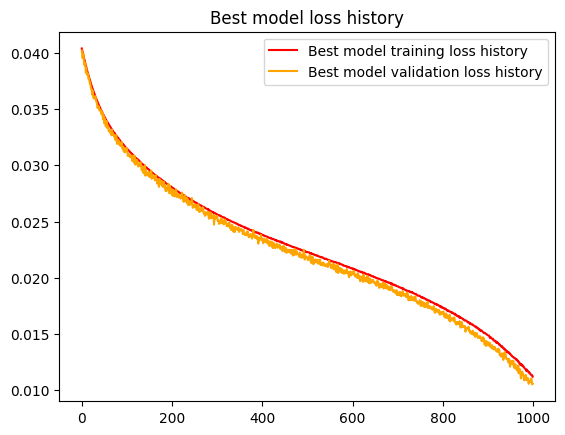

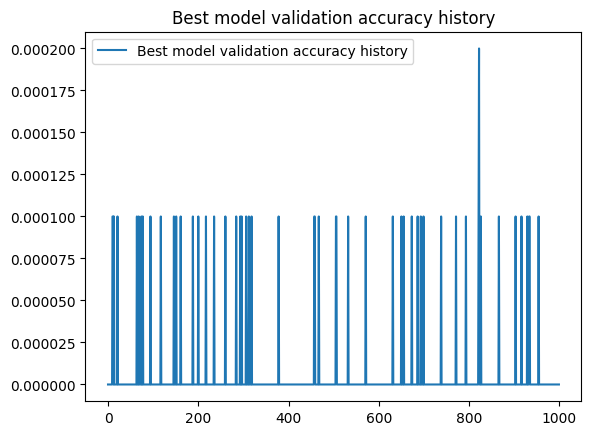


Best Model Training Loss: 0.011214940247312188
Best Model Validation Loss: 0.010581046618521214
Best Model Accuracy: 0.0


Fold	Training Loss	Validation Loss	Validation Accuracy
-1	0.011214940247312188	0.010581046618521214	0.0

Average Performance Metrics of Model
Average Training Loss 0.003738313415770729
Average Validation Loss 0.003527015539507071
Average Validation Accuracy 0.0


In [20]:
# get best model
model, model_history, _ = get_model_data(exp_params["model"]["name"])
#model = get_saved_model(model, '')
model_info = get_modelinfo('')

print("\nModel validation results")
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()




Testing Saved Model


<Figure size 640x480 with 0 Axes>

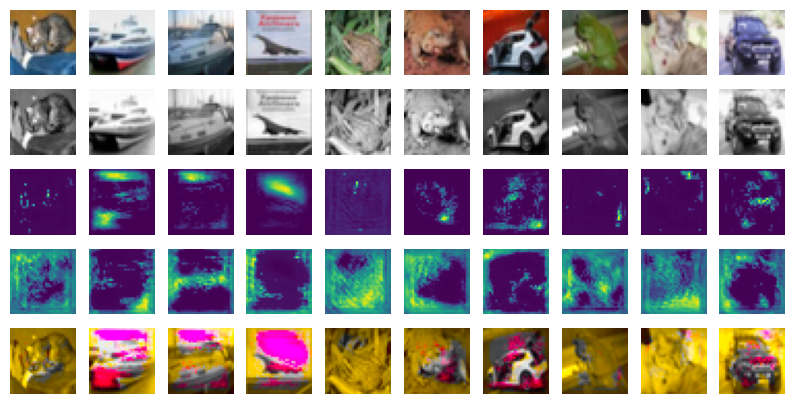


Test Loss: 1.0078535079956055
Test Accuracy: tensor(0.) 



In [13]:
#model testing
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, te_dataset)
mt.test_and_plot(ds["RGBte"], "best_model", True)